In [56]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
#* magic to add python path to notebook environment
import sys
pypath = sys.path[0]
%env PYTHONPATH $pypath

import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rich import print
from particle import Particle
from scipy.interpolate import interp1d
import scipy.stats as stats

from python.analysis import Master, Plots, cross_section, vector, Fitting
from python.analysis import BeamParticleSelection

cross_section.PlotStyler.SetPlotStyle(dpi = 100, extend_colors = True)

def truth_regions(events : Master.Data) -> dict:
    """ masks to select particle which interact in a particular channel or "region". these truth regions reflect the channels defined in the simulation.

    Args:
        events (Master.Data): events to look at.

    Returns:
        dict: dictionary of masks.
    """
    inelastic = events.trueParticles.true_beam_endProcess == "pi+Inelastic"
    absorption = inelastic & (events.trueParticles.nPiPlus == 0) & (events.trueParticles.nPi0 == 0) & (events.trueParticles.nPiMinus == 0)
    cex = (events.trueParticles.nPiPlus == 0) & (events.trueParticles.nPi0 == 1) & (events.trueParticles.nPiMinus == 0)
    quasielastic = (events.trueParticles.nPiPlus == 1) & (events.trueParticles.nPi0 == 0) & (events.trueParticles.nPiMinus == 0)
    double_cex = (events.trueParticles.nPiPlus == 0) & (events.trueParticles.nPi0 == 0) & (events.trueParticles.nPiMinus == 1)
    pion_production = inelastic & (~absorption) & (~cex) & (~quasielastic) & ~(double_cex)
    return {"total_inelastic" : inelastic, "absorption" : absorption, "charge_exchange" : cex, "quasielastic" : quasielastic, "double_charge_exchange" : double_cex, "pion_production" : pion_production, "single_pion_production" : double_cex | quasielastic}


def EsliceDemo(events : Master.Data, e_min : float, e_max : float, e_width : float):
    """ Demonstation on how to use the EnergySlice to compute cross sections using MC truth.

    Args:
        events (Master.Data): events to look at
        e_min (float): minimum energy range
        e_max (float): maximum energy range
        e_width (float): energy slice width
    """
    cross_sections = cross_section.GeantCrossSections(energy_range = [e_min, e_max]) # get cross sections from simulation

    energy_slices = cross_section.Slices(e_width, e_min, e_max, reversed = True) # define energy slices

    #* true interacting kinetic energy
    true_int_KE = events.trueParticles.beam_traj_KE[:, -2] # -1 is always zero for kinetic energy trajectory points, to take -2

    #* true front facing kinetic energy
    ind = ak.argmax(events.trueParticles.beam_traj_pos.z > 0, -1, keepdims = True)

    true_ffKE = ak.where(ak.flatten(events.trueParticles.beam_traj_pos.z[ind]) < 0, 999999, events.trueParticles.beam_KE_front_face) # set KE to 999999 if the particle didn't reach the TPC.
    outside_tpc = true_ffKE >= 999999 # don't count events outside the TPC

    mean_dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slices, Particle.from_pdgid(211)) # dEdX at each energy slice

    #* evalutate and plot for each exclusive cross section
    regions = truth_regions(events) # get truth regions
    for i, region in Plots.IterMultiPlot(regions):
        print(f"evaluating {region} region")
        _, _, n_interact, n_incident = cross_section.EnergySlice.CountingExperiment(true_int_KE, true_ffKE, outside_tpc, regions[region], energy_slices)
        xs = cross_section.EnergySlice.CrossSection(n_interact, n_incident, mean_dEdX, energy_slices.width)
        Plots.Plot(energy_slices.pos[1:], xs[0][1:], yerr = xs[1][1:], xerr = energy_slices.width/2, marker = "x", linestyle = "", newFigure = False, label = "MC truth", xlabel = "KE (MeV)", ylabel = "$\sigma$(mb)")
        cross_sections.Plot(region, label = "Geant4 simulation", color = "C6", title = f"{region}: {ak.sum(regions[region])}")
        plt.xlim(e_min - e_width, e_max + e_width)


def ThinSliceDemo(events : Master.Data, z_range : list, e_range : list, slice_width : float):
    """ Demonstation on how to use the ThinSlice to compute cross sections using MC truth.

    Args:
        events (Master.Data): events to look at
        z_range (list): spatial slice range
        e_range (list): energy range
        slice_width (float): spatial slice width
    """
    cross_sections = cross_section.GeantCrossSections(energy_range = e_range) # get cross sections from simulation

    slices = cross_section.Slices(slice_width, min(z_range), max(z_range)) # define spatial slices

    interact_position = events.trueParticles.endPos.z[:, 0] # get interaction vertex z position

    traj_KE = events.trueParticles.beam_traj_KE # get beam particle kinetic energy at each trajectory point from simulation
    traj_pos = events.trueParticles.beam_traj_pos.z # get beam particle z at each trajectory point from simulation 

    regions = truth_regions(events) # get truth regions
    mean_slice_energy, mean_error_slice_energy = cross_section.ThinSlice.MeanSliceEnergy(traj_KE, traj_pos, slices) # get average particle energy in each slice

    n_int, n_inc = cross_section.ThinSlice.CountingExperiment(interact_position, np.ones(len(interact_position), dtype = bool), slices)
    #* evalutate and plot for each exclusive cross section
    for i, region in Plots.IterMultiPlot(regions):
        print(f"evaluating {region} region")

        n_int_ex = cross_section.ThinSlice.CountingExperiment(interact_position, regions[region], slices)[0]
        xs = cross_section.ThinSlice.CrossSection(n_int_ex, n_int, n_inc, slices.width/ 0.95)
        Plots.Plot(mean_slice_energy[1:-1], xs[0][1:-1], yerr = xs[1][1:-1], xerr = mean_error_slice_energy[1:-1], xlabel = "average $\pi^{+}$ kinetic energy before interacting (MeV)", ylabel = "$\sigma$(mb)", linestyle = "", marker = "x", newFigure = False, label = "MC truth")
        cross_sections.Plot(region, label = "Geant4 simulation", color = "C6", title = f"{region}: {ak.sum(regions[region])}")
        plt.xlim(min(e_range), max(e_range))
        plt.ylim(0, 1.25 * max(getattr(cross_sections, region)))


def LoadSample(config : str, nEvents : int, start : int, selection : str) -> Master.Data:
    """ Load root file and select only true pions.

    Args:
        file (str): root file
        nEvents (int): number of events

    Returns:
        Master.Data: true pion events
    """
    args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration(config))
    events = Master.Data(args.mc_file, nTuple_type = Master.Ntuple_Type.PDSP, nEvents = nEvents, start = start)
    
    if "reco" in selection:
        mask = BeamParticleSelection.CreateDefaultSelection(events, False, cross_section.LoadConfiguration(args.mc_beam_quality_fit), 211, True, cross_section.LoadConfiguration(args.mc_beam_scraper_fit), 1, 1.5, return_table = False)
        events.Filter([mask], [mask])
    if "true" in selection:
        mask = events.trueParticles.pdg[:, 0] == 211
        events.Filter([mask], [mask])

    return events

def ThinsliceCrossSection(endPos, channel, slices, correct_width : bool = True) -> tuple[np.array]:
    output = {}
    output["n_interact"], output["n_incident"] = cross_section.ThinSlice.CountingExperiment(endPos, np.ones(len(channel), dtype = bool), slices)
    output["n_interact_exclusive"] = cross_section.ThinSlice.CountingExperiment(endPos, channel, slices)[0]
    # output["xs"], output["xs_err"] = cross_section.ThinSlice.CrossSection(output["n_incident"], output["n_interact"], slices.width / 0.95)
    width = slices.width
    if correct_width: width = width/0.95
    output["xs"], output["xs_err"] = cross_section.ThinSlice.CrossSection(output["n_interact_exclusive"], output["n_interact"], output["n_incident"], width)
    return output


# def ThinsliceCrossSection(endPos, channel, slices) -> tuple[np.array,np.array,np.array,np.array]:
#     output = {}
#     output["n_interact"], output["n_incident"] = cross_section.ThinSlice.CountingExperiment(endPos, channel, slices)
#     output["xs"], output["xs_err"] = cross_section.ThinSlice.CrossSection(output["n_incident"], output["n_interact"], slices.width / 0.95)
#     return output


def ESliceCrossSection(KE_int : ak.Array, KE_init : ak.Array, channel : ak.Array, outside_tpc : ak.Array, slices : cross_section.Slices, particle : Particle) -> tuple[np.array]:
    output = {}
    _, _, output["n_interact"], output["n_incident"] = cross_section.EnergySlice.CountingExperiment(KE_int, KE_init, outside_tpc, channel, slices)
    dEdX = cross_section.EnergySlice.Slice_dEdX(slices, particle)
    output["xs"], output["xs_err"] = cross_section.EnergySlice.TotalCrossSection(output["n_interact"][1:], output["n_incident"][1:], dEdX, slices.width)
    return output

def ESliceCrossSectionModified(KE_int : ak.Array, KE_init : ak.Array, exclusive_channel : ak.Array, outside_tpc : ak.Array, slices : cross_section.Slices, particle : Particle) -> tuple[np.array]:
    output = {}
    output["n_initial"], output["n_end"], output["n_interact_exclusive"], output["n_incident"] = cross_section.EnergySlice.CountingExperiment(KE_int, KE_init, outside_tpc, exclusive_channel, slices)
    dEdX = cross_section.EnergySlice.Slice_dEdX(slices, particle)
    output["xs"], output["xs_err"] = cross_section.EnergySlice.CrossSection(output["n_interact_exclusive"][1:], output["n_end"][1:], output["n_incident"][1:], dEdX, slices.width)
    return output


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PYTHONPATH=/home/sb16165/Documents/pi0-analysis/analysis


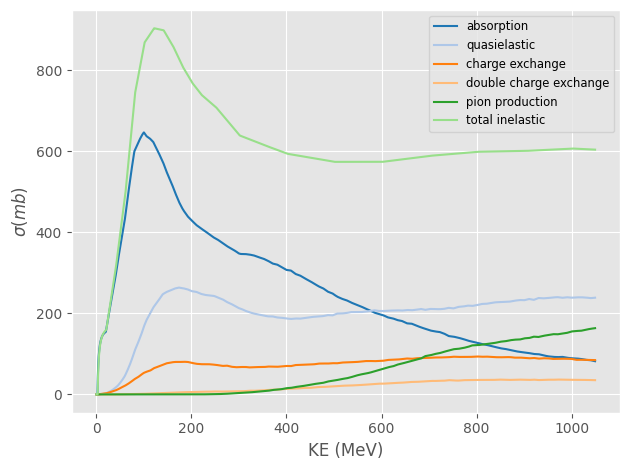

In [3]:
cross_sections = cross_section.GeantCrossSections(energy_range = [0, 1050])
cross_sections.Plot("all")

In [5]:
config = "test/analysis_1GeV/analysis_config.json"
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration(config))
events = LoadSample(config, -1, 0, "true")#149097
# events_test = LoadSample(config, 149097, 149097, "true")

# events = LoadSample("work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", 149097)#149097
# events = LoadSample("work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", 70774)#70774

# Slices based on position

can slice up a TPC into thin slice targets based on the collection wire spacing.

By the conventions used by others, a single slice contains 20 wires, so is 10cm in thinkness (collection plane wire pitch is 5mm)

In [7]:
spatial_slices = cross_section.Slices(10, -10, 720)

Now we do the counting experiment. the cross section in a single slice is:
$$
    \sigma = \frac{M_{Ar}}{\rho t N_{A}}\log\left( \frac{N_{incident}}{N_{incident} - N_{interact}} \right)
$$

 - $t$ is the thickness of each slice
 - $N_{incident}$ is the number of incident beam particles in the slice
 - $N_{interact}$ is the number of interacting beam particles in the slice (i.e. the end of the beam particle trajectory)

Alrogithm to count $N_{indicent}$ and $N_{interact}$ is as follows:

 1. Create `N_{indicent}` and `N_{interact}` bins for each slice.
 1. loop over each beam particle and find the end trajectory point
 2. calculate which slice the end trajectory point falls in `end_slice = floor(z/t)`
 3. add 1 to `end_slice` in `N_{interact}` bins and add 1 to every slice before and including `end_slice` in `N_{indicent}` (this makes the assumption the beam particle travelled through every slice before the final one.)


n_interact=array([18739, 15088, 13159, 11756, 10132,  8669,  7560,  6813,  5806,
        5019,  4403,  3868,  3356,  2921,  2590,  2287,  2066,  1816,
        1571,  1412,  1256,  1104,   966,   826,   747,   684,   613,
         506,   426,   372,   350,   286,   209,   175,   123,    91,
          47,    38,    18,     8,     5,     0,     2,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

n_incident=array([144230, 122151, 106828,  93488,  81561,  71255,  62443,  54756,
        47843,  41933,  36817,  32327,  28380,  24951,  21964,  19328,
        16986,  14859,  13007,  11392,   9948,   8649,   7519,   6526,
         5670,   4895,   4192,   3540,   3003,   2550,   2148,   1756,
         1415,   1148,    873,    651,    460,    306,    185,    100,
           50,     21,      7,      2,      1,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0])

Text(0.5, 0, 'interaction vertex z(cm)')

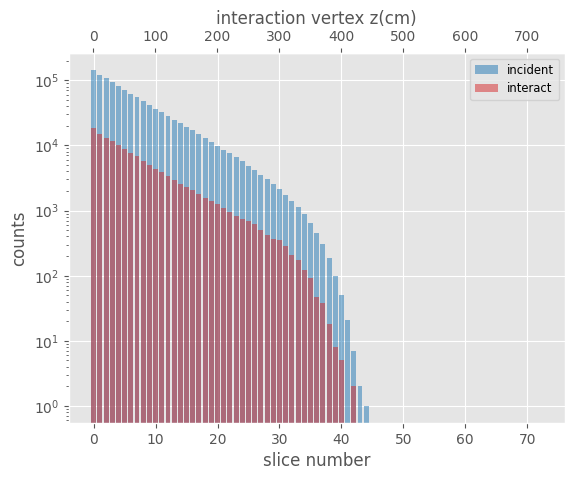

In [6]:
regions = truth_regions(events)
n_interact, n_incident = cross_section.ThinSlice.CountingExperiment(events.trueParticles.endPos.z[:, 0], regions["total_inelastic"], spatial_slices) # using trajectory points gives wierd results, compare the two to see what is different.

print(f"{n_interact=}")
print(f"{n_incident=}")

plt.bar(spatial_slices.num[1:], n_incident, alpha = 0.5, label = "incident")
plt.bar(spatial_slices.num[1:], n_interact, alpha = 0.5, label = "interact", color = "C6")
plt.yscale("log")
plt.xlabel("slice number")
plt.ylabel("counts")
plt.legend()

def f(x):
    return (x + 0.5) * spatial_slices.width

def g(x):
    return x // spatial_slices.width

sax = plt.gca().secondary_xaxis("top", functions = (f, g))
sax.set_xlabel("interaction vertex z(cm)")


Plot the cross section as a function of slice number

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:693: RuntimeWarning: invalid value encountered in divide
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:696: RuntimeWarning: invalid value encountered in divide
  v_interact = n_interact*(1- (n_interact/n_incident)) # binomial uncertainty
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:698: RuntimeWarning: divide by zero encountered in divide
  xs_e = (1/n_incident) * (1/(n_incident - n_interact)) * (n_interact**2 * v_incident + n_incident**2 * v_interact)**0.5


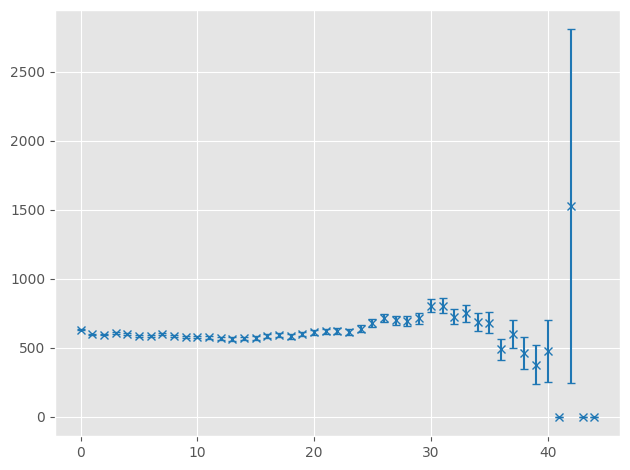

In [8]:
xs = cross_section.ThinSlice.CrossSection(n_incident, n_interact, spatial_slices.width/0.95)
Plots.Plot(spatial_slices.num[1:-1], xs[0][:-1], yerr = xs[1][:-1], marker = "x", linestyle = "")

Plot the cross section as a function of the avergae $\pi^{+}$ Kinetic energy in each slice

In [62]:
def MPSliceEnergy(events : Master.Data, slices : cross_section.Slices) -> tuple[np.array, np.array]:
    """ finds the mode energy in each thin slice.

    Args:
        events (Master.Data): events to look at
        slices (cross_section.Slices): spatial slices

    Returns:
        tuple[np.array, np.array]: mode, error in the mode
    """
    nums = slices.pos_to_num(events.trueParticles.beam_traj_pos.z[:, :-1])

    mpv = []
    mpv_e = []
    for i in range(1, len(slices.num)):
        sample = nums == slices[i].num
        h, e = np.histogram(ak.ravel(events.trueParticles.beam_traj_KE[:, :-1][sample]), 100)
        c = (e[1:] + e[:-1]) / 2
        mpv.append(c[np.argmax(h)])
        mpv_e.append(abs((e[0] - e[1]) / 2))
    return np.array(mpv), np.array(mpv_e)


def MedianSliceEnergy(events : Master.Data, slices : cross_section.Slices) -> tuple[np.array, np.array]:
    """ finds the median energy ins each thin slice.

    Args:
        events (Master.Data): events to look at
        slices (cross_section.Slices): spatial slices

    Returns:
        tuple[np.array, np.array]: median, error in the median (taken to be the error in the mean)

    """
    nums = slices.pos_to_num(events.trueParticles.beam_traj_pos.z[:, :-1])

    median = []
    median_e = []
    for i in range(1, len(slices.num)):
        sample = nums == slices[i].num
        h, e = np.histogram(ak.ravel(events.trueParticles.beam_traj_KE[:, :-1][sample]), 100)
        c = (e[1:] + e[:-1]) / 2
        median.append(c[np.argmax(h)])
        median_e.append(np.std(ak.ravel(events.trueParticles.beam_traj_KE[:, :-1][sample]) / np.sqrt(ak.sum(sample))))
    return np.array(median), np.array(median_e)

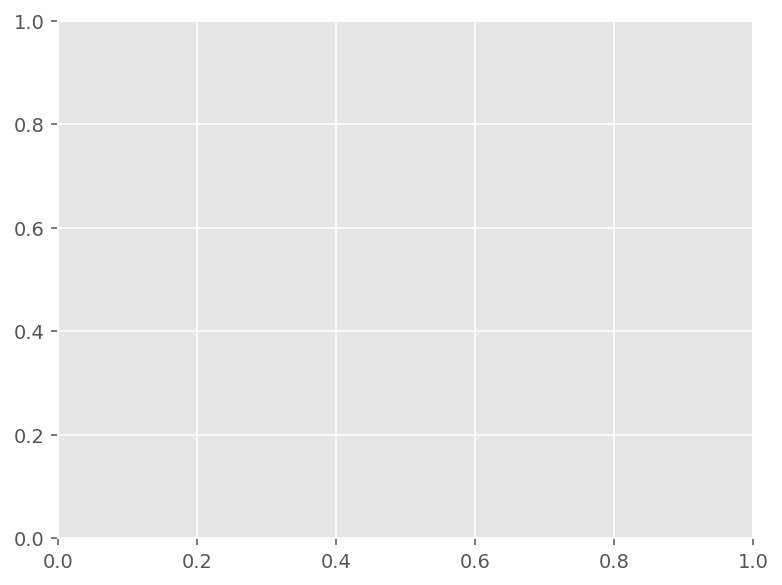

In [76]:
import matplotlib.backends.backend_pdf


with matplotlib.backends.backend_pdf.PdfPages("thin_slice_true_energies_1GeV.pdf") as pdf:
    nums = spatial_slices.pos_to_num(events.trueParticles.beam_traj_pos.z[:, :-1])

    for i in range(len(spatial_slices.num)):
        sample = nums == spatial_slices[i].num
        Plots.PlotHist(ak.ravel(events.trueParticles.beam_traj_KE[:, :-1][sample]), title = spatial_slices[i], xlabel = "KE (MeV)", range = [0, 1000])
        plt.xlim(0, 1000)
        pdf.savefig()
        plt.close()
        plt.cla()

    for i in Plots.MultiPlot(len(spatial_slices.num)):
        sample = nums == spatial_slices[i].num
        Plots.PlotHist(ak.ravel(events.trueParticles.beam_traj_KE[:, :-1][sample]), title = spatial_slices[i], xlabel = "KE (MeV)", range = [0, 1000], newFigure = False)
        plt.xlim(0, 1000)
    pdf.savefig()
    plt.close()
    plt.cla()


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:695: RuntimeWarning: invalid value encountered in divide
  mean_energy = sum_energy / counts
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:697: RuntimeWarning: invalid value encountered in divide
  std_energy = np.divide(sum_energy_sqr, counts) - mean_energy**2


Text(0.5, 0, 'interaction vertex z(cm)')

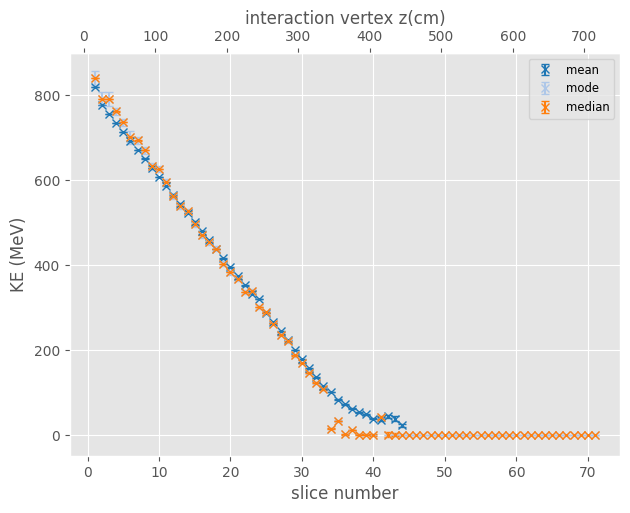

In [21]:
mean_energy = cross_section.ThinSlice.MeanSliceEnergy(events.trueParticles.beam_traj_KE, events.trueParticles.beam_traj_pos.z, spatial_slices)

mpv_energy = MPSliceEnergy(events, spatial_slices)
medain_energy = MedianSliceEnergy(events, spatial_slices)

plt.figure()
for e, l in zip([mean_energy, mpv_energy, medain_energy], ["mean", "mode", "median"]):
    Plots.Plot(spatial_slices.num[2:-1], e[0][1:-1], yerr = e[1][1:-1], marker = "x", linestyle = "", xlabel = "slice number", label = l, ylabel = "KE (MeV)", newFigure = False)
sax = plt.gca().secondary_xaxis("top", functions = (f, g))
sax.set_xlabel("interaction vertex z(cm)")

(0.0, 1200.0)

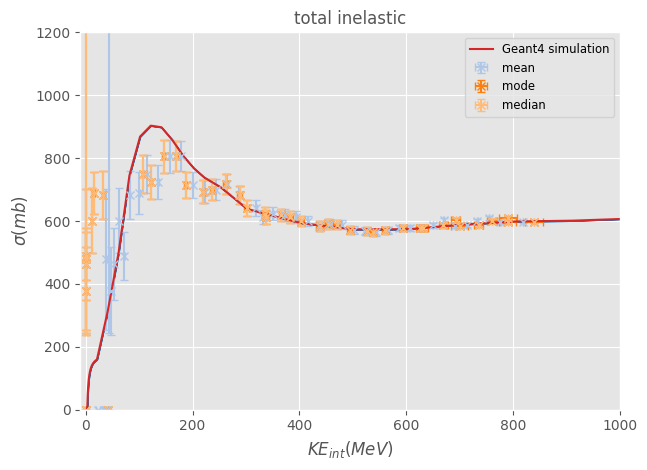

In [22]:
valid = slice(1, -1, 1)
plt.figure()
cross_sections.Plot("total_inelastic", color = "C6", label = "Geant4 simulation")
for e, l in zip([mean_energy, mpv_energy, medain_energy], ["mean", "mode", "median"]):
    Plots.Plot(e[0][valid], xs[0][valid], xerr = e[1][valid], yerr = xs[1][valid], marker = "x", linestyle = "", label = l, newFigure = False)

plt.xlim(-10, 1000)
plt.ylim(0, 1200)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:695: RuntimeWarning: invalid value encountered in divide
  mean_energy = sum_energy / counts
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:697: RuntimeWarning: invalid value encountered in divide
  std_energy = np.divide(sum_energy_sqr, counts) - mean_energy**2


evaluating total_inelastic region

evaluating absorption region

evaluating charge_exchange region

evaluating quasielastic region

evaluating double_charge_exchange region

evaluating pion_production region

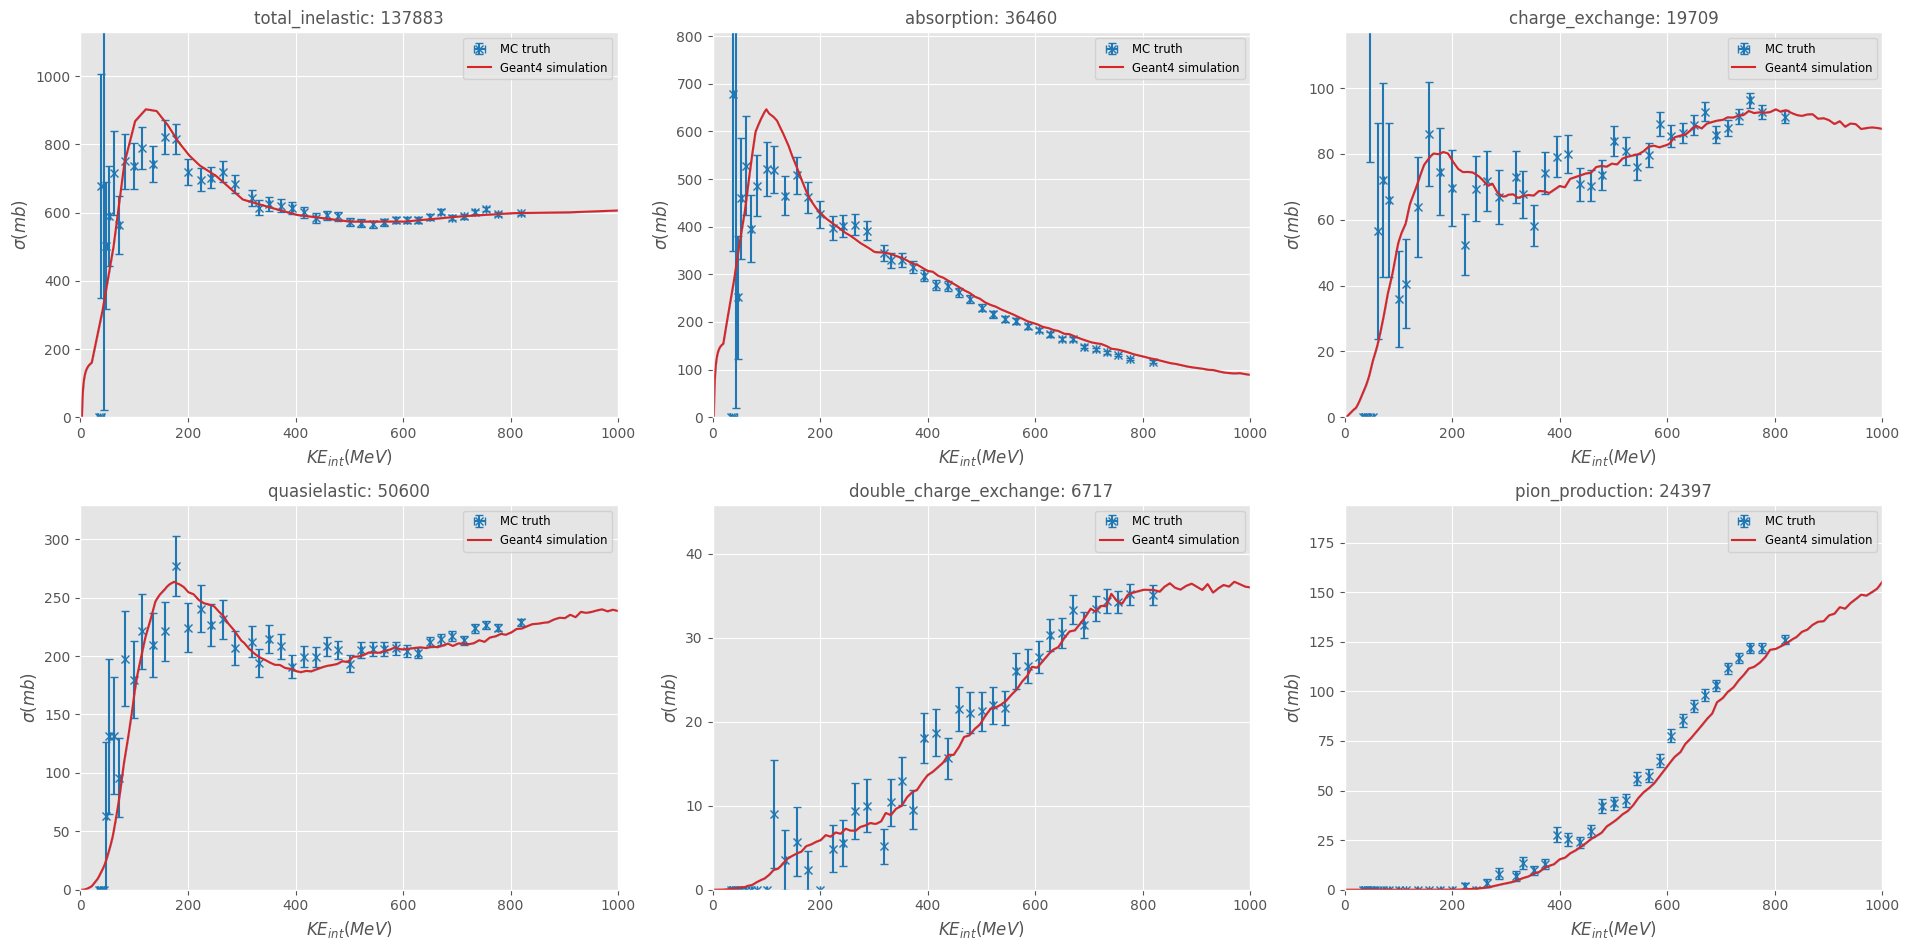

In [39]:
ThinSliceDemo(events, [-10, 720], [0, 1000], 10)

In [98]:
for i, s in Plots.IterMultiPlot(spatial_slices):
    mask = spatial_slices.pos_to_num(events.trueParticles.beam_traj_pos.z) == s.num
    energy = events.trueParticles.true_beam_traj_KE[mask]
    Plots.PlotHist(ak.ravel(energy), newFigure = False, title = s.__str__(), range = [0, 1500], xlabel = "True Kinetic Energy (MeV)")

# Slices Based on Energy

instead of computing the slices based on the wire pitch, use the energy loss of the particle and define slices in energy instead. This means the slice thickness is now in terms of $\delta E$ and the spacial thickness is:

$$
    t_{i} = \frac{\delta E}{ \left.\frac{dE}{dX}\right|_{\left< E_{i} \right>} }
$$

where i is the slice number, $dE/dX$ is the energy loss per unit length and $E_{i}$ is the particle energy exiting the slice.

i.e. the slice thickness is the distance the particle travels before it looses $\delta E$ worth of energy.

Now the cross section formula becomes:

$$
\sigma_{i} = \frac{M_{Ar}}{\rho N_{A} \delta E} \left.\frac{dE}{dX}\right|_{\left< E_{i} \right>} \log\left( \frac{N_{incident}}{N_{incident} - N_{interact}} \right)
$$

And really is a function of the particle kinetic energy rather than the averge kinetic energy in a slice.

By convention, $\delta E$ is set to 50MeV (not sure why) and now the slice thickness need to be calculated per particle

Now, the counting will work in a similar way, but we can no longer assume the particle travels through all slices because the initial kinetic energy of the beam particle vill vary. So as well as the end slice, an initial slice must be found.

The initial slice is `ceil((plim - KE_ini)//dE)`

The end slice is still the last trajectory point, but the slice number needs to be found based on the energy the particle had before interacting with the target

870.1225800481984

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:170: RuntimeWarning: invalid value encountered in double_scalars
  beta = (1 - (1/gamma)**2)**0.5


-44.135129713718406

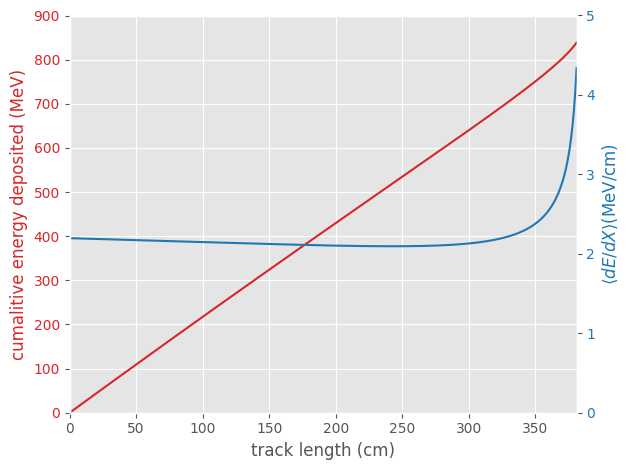

In [40]:
KE = ((1000)**2 + (Particle.from_pdgid(211).mass)**2)**0.5 - Particle.from_pdgid(211).mass
print(KE)
total_energy_deposited = [0]
dEdX = [cross_section.BetheBloch.meandEdX(KE, Particle.from_pdgid(211))]

pitch = 1 # cm

while KE > 0:
    total_energy_deposited.append(total_energy_deposited[-1] + dEdX[-1] * pitch)
    KE -= dEdX[-1] * pitch
    dEdX.append(cross_section.BetheBloch.meandEdX(KE, Particle.from_pdgid(211)))
print(KE)

total_energy_deposited = np.array(total_energy_deposited)
dEdX = np.array(dEdX)

trk_len = np.arange(0, pitch * len(dEdX), pitch)

dEdX = dEdX[trk_len <= 381]
total_energy_deposited = total_energy_deposited[trk_len <= 381]
trk_len = trk_len[trk_len <= 381]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('track length (cm)')
ax1.set_ylabel('cumalitive energy deposited (MeV)', color=color)
ax1.plot(trk_len, total_energy_deposited, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel("$\left<dE/dX\\right>$(MeV/cm)", color=color)  # we already handled the x-label with ax1
ax2.plot(trk_len, dEdX, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(False)

ax1.set_ylim(0, 900)
ax2.set_ylim(0, 5)
plt.xlim(0, 381)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


(2.0, 5.2)

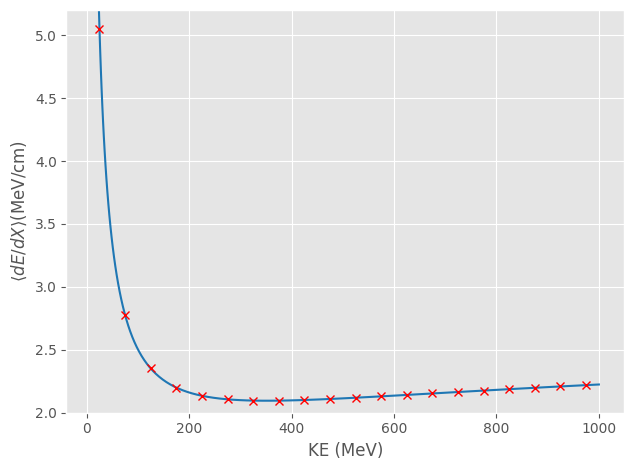

In [41]:
Plots.Plot(np.logspace(1, 3, 100), cross_section.BetheBloch.meandEdX(np.logspace(1, 3, 100), Particle.from_pdgid(211)))
Plots.Plot(np.arange(0, 1000, 50) + 25, cross_section.BetheBloch.meandEdX(np.arange(0, 1000, 50) + 25, Particle.from_pdgid(211)), marker = "x", color = "red", newFigure = False, linestyle = "", xlabel = "KE (MeV)", ylabel = "$\left<dE/dX\\right>$(MeV/cm)")
plt.ylim(2, 5.2)

In [42]:
true_int_KE = events.trueParticles.beam_traj_KE[:, -2] # -1 is always zero for kinetic energy trajectory points, to take -2

true_ffKE = ak.where(events.trueParticles.beam_KE_front_face < 0, 999999, events.trueParticles.beam_KE_front_face) ## set KE to 999999 if the particle didn't reach the TPC.

spatial_slices = cross_section.Slices(20, 0, 1020, reversed = True)

print(f"{true_int_KE=}")
print(f"{true_ffKE=}")

true_int_KE=<Array [762, 637, 824, 922, ... 745, 921, 958] type='144230 * float64'>

true_ffKE=<Array [788, 897, 879, 929, ... 842, 925, 958] type='144230 * ?float64'>

np.unique(true_init_slice, return_counts=True)=(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 
14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50,
       51]), array([  574,   114,   310,  1291,  3645,  6917, 10937, 14563, 16909,
       18249, 17959, 16414, 13008,  8661,  5326,  3245,  1768,  1196,
         849,   637,   531,   372,   242,   155,    84,    44,    29,
          15,    19,    16,    11,     9,     7,     4,     7,     1,
           5,     5,     6,     2,     8,     6,     4,     8,     2,
           3,     5,     4,     2,     1,     2,    49]))

np.unique(true_int_slice, return_counts=True)=(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 
14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51]), array([18721,    41,    83,   257,   632,  1425,  2481,  3681,  4881,
        6184,  7471,  7948,  8523,  7976,  7770,  7002,  6402,  5775,
        4989,  4601,  4011,  3552,  3186,  2810,  2596,  2239,  2066,
        1841,  1641,  1435,  1413,  1244,  1024,   947,   884,   777,
         688,   609,   617,   468,   422,   395,   357,   336,   283,
         246,   194,   133,    86,    50,    23,    17,   797]))

Text(0.5, 0, 'KE (MeV)')

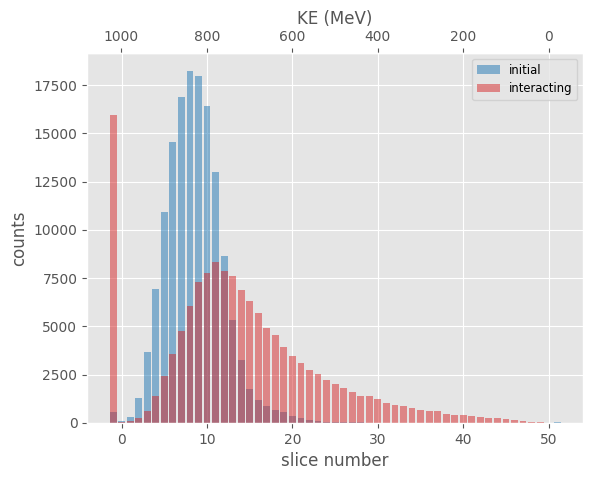

In [43]:
regions = truth_regions(events)

true_init_slice = spatial_slices(true_ffKE).num + 1 # equivilant to ceil
true_int_slice = spatial_slices(true_int_KE).num

true_init_slice = cross_section.EnergySlice.TrunacteSlices(true_init_slice, spatial_slices)
true_int_slice = cross_section.EnergySlice.TrunacteSlices(true_int_slice, spatial_slices)

# just in case we encounter an instance where E_int > E_ini (unphysical)
bad_slices = true_int_slice < true_init_slice
true_init_slice = ak.where(bad_slices < 0, -1, true_init_slice)
true_int_slice = ak.where(bad_slices, -1, true_int_slice)

print(f"{np.unique(true_init_slice, return_counts=True)=}")
print(f"{np.unique(true_int_slice, return_counts=True)=}")

plt.bar(*np.unique(true_init_slice, return_counts = True), alpha = 0.5, label = "initial")
plt.bar(*np.unique(true_int_slice[regions["total_inelastic"]], return_counts = True), alpha = 0.5, color = "C6", label = "interacting")
plt.xlabel("slice number")
plt.ylabel("counts")
plt.legend()

def f(x):
    return (spatial_slices.max_num - x - 1.5) * spatial_slices.width

def g(x):
    return ((spatial_slices.max - x) // spatial_slices.width) + 1.5

sax = plt.gca().secondary_xaxis("top", functions = (f, g))
sax.set_xlabel("KE (MeV)")

[18887   262   484  1496  4276  9589 17541 27740 38764 49679 59205 66106
 69577 68732 65486 60616 55199 49899 44902 40498 36389 32723 29393 26354
 23623 21066 18854 16803 14980 13353 11929 10524  9287  8267  7326  6443
  5671  4988  4384  3769  3309  2890  2499  2148  1813  1532  1286  1097
   968   884   835   814   797]

[15957    38    80   233   616  1368  2401  3549  4757  6049  7296  7775
  8340  7849  7612  6891  6299  5680  4926  4526  3944  3485  3110  2740
  2536  2190  2014  1796  1602  1397  1375  1216   998   917   861   751
   665   594   592   460   406   376   343   320   265   236   187   127
    78    41    14     5     0]

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (52,) and arg 1 with shape (53,).

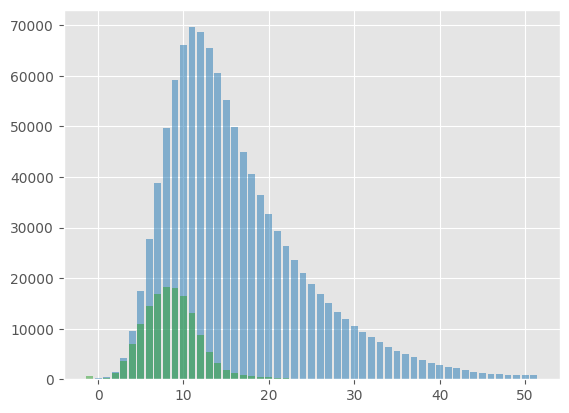

In [45]:
outside_tpc = true_ffKE >= 999999 # don't count events outside the TPC
_, _, n_interact, n_incident = cross_section.EnergySlice.CountingExperiment(true_int_KE, true_ffKE, outside_tpc, regions["total_inelastic"], spatial_slices)

print(n_incident)
print(n_interact)

plt.bar(spatial_slices.num, n_incident[1:], alpha = 0.5, label = "incident")
plt.bar(*np.unique(true_init_slice, return_counts = True), color = "C4", alpha = 0.5, label = "initial")
plt.bar(spatial_slices.num, n_interact, alpha = 0.5, color = "C6", label = "interacting")
plt.xlabel("slice number")
plt.ylabel("counts")
plt.yscale("log")
plt.legend()

def f(x):
    return (spatial_slices.max_num - x - 1.5) * spatial_slices.width

def g(x):
    return ((spatial_slices.max - x) // spatial_slices.width) + 1.5

sax = plt.gca().secondary_xaxis("top", functions = (f, g))
sax.set_xlabel("KE (MeV)")


/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:164: RuntimeWarning: invalid value encountered in sqrt
  beta = (1 - (1/gamma)**2)**0.5
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(


(0.0, 1200.0)

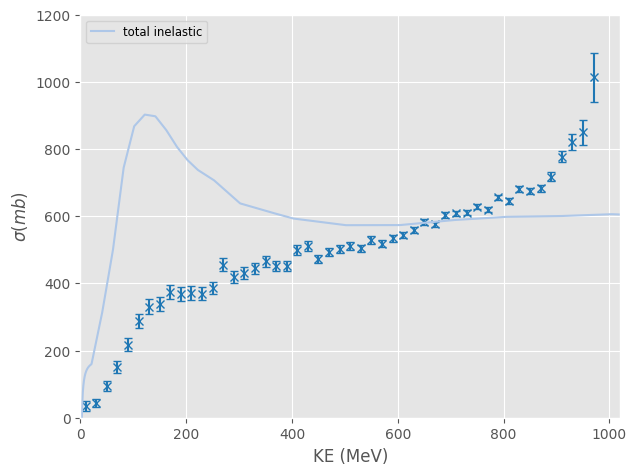

In [9]:
dEdX = cross_section.EnergySlice.Slice_dEdX(spatial_slices, Particle.from_pdgid(211))
xs = cross_section.EnergySlice.CrossSection(n_interact, n_incident, dEdX, spatial_slices.width)

Plots.Plot(spatial_slices.pos - spatial_slices.width/2, xs[0], yerr = xs[1], marker = "x", linestyle = "")

cross_sections.Plot("total_inelastic")
plt.xlim(0, spatial_slices.max)
plt.ylim(0, 1200)

In [68]:
print( (cross_section.BetheBloch.meandEdX(40, Particle.from_pdgid(211))/40)**-1 )

10.586429084369557

evaluating total_inelastic region

evaluating absorption region

evaluating charge_exchange region

evaluating quasielastic region

evaluating double_charge_exchange region

evaluating pion_production region

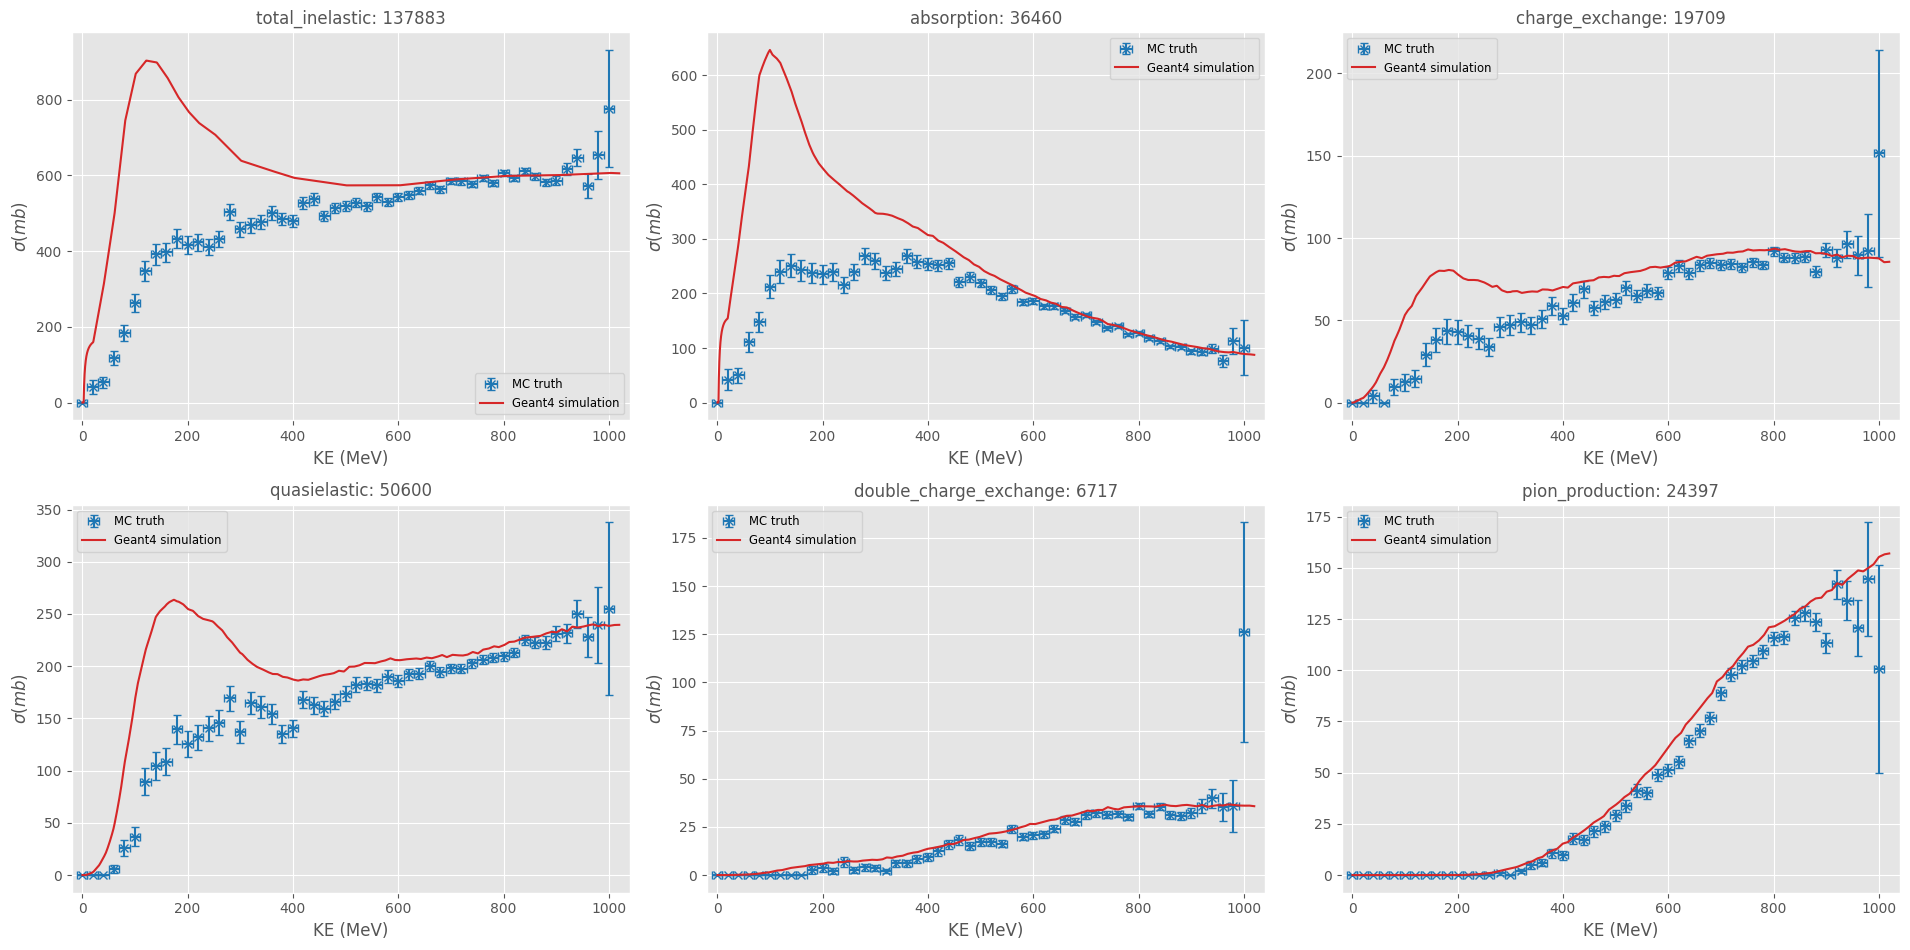

In [10]:
EsliceDemo(events, 0, 1020, 20)

In [374]:
"""
https://indico.fnal.gov/event/52248/
https://indico.fnal.gov/event/52663/contributions/232060/attachments/150781/194577/Hadron%20Meeting%201_13_22.pdf
https://indico.fnal.gov/event/52248/contributions/230130/attachments/150183/193605/Hadron%20Analysis%20Meeting%209%20Dec%202021.pdf
https://indico.fnal.gov/event/47844/contributions/208964/attachments/140192/176119/xs_validation_mcTrue_Prod4_02_18_21.pdf
https://indico.fnal.gov/event/54192/contributions/239696/attachments/154284/200404/Hadron%20Meeting%204-21-22.pdf
https://indico.fnal.gov/event/47844/contributions/208964/attachments/140192/176119/xs_validation_mcTrue_Prod4_02_18_21.pdf
https://indico.fnal.gov/event/55164/contributions/245011/attachments/156673/204588/pionXS_HadAna_220630.pdf

https://indico.fnal.gov/event/54122/contributions/239293/attachments/154088/200097/Hadron%20Meeting%204-14-22.pdf

https://indico.fnal.gov/event/53325/contributions/235193/attachments/152412/197326/pionXS_DRA_220223.pdf
"""

[None, None, None, None, None]

# Combined Study

In [53]:
def ThinSliceResults(events : Master.Data, slices : cross_section.Slices, regions : dict) -> dict:
    """ Do Thin slice study for MC truth.

    Args:
        events (Master.Data): events to look at
        slices (Slices): spatial slices
        regions (dict): truth regions

    Returns:
        dict: cross sections for each region.
    """
    interact_position = events.trueParticles.endPos.z[:, 0]
    xs = {}
    for r in regions:
        n_int, n_inc = cross_section.ThinSlice.CountingExperiment(interact_position, np.ones(len(interact_position), dtype = bool), slices)
        n_int_ex, _ = cross_section.ThinSlice.CountingExperiment(interact_position, regions[r], slices)
        xs[r] = cross_section.ThinSlice.CrossSection(n_int_ex, n_int, n_inc, slices.width/ 0.95)
    return xs


def ThinSliceMeanEnergy(events : Master.Data, slices : cross_section.Slices, regions : dict) -> tuple[ak.Array, ak.Array]:
    """ mean energy for each thin slice.

    Args:
        events (Master.Data): events to look at
        slices (Slices): spatial slices
        regions (dict): truth regions

    Returns:
        tuple[ak.Array, ak.Array]: _description_
    """
    traj_KE = events.trueParticles.beam_traj_KE
    traj_pos = events.trueParticles.beam_traj_pos.z

    mean_slice_energy = cross_section.ThinSlice.MeanSliceEnergy(traj_KE[regions["total_inelastic"]], traj_pos[regions["total_inelastic"]], slices)
    return mean_slice_energy


def EnergySliceResults(events : Master.Data, slices : cross_section.Slices, regions : dict) -> dict:
    """ Do Energy slice study for MC truth.

    Args:
        events (Master.Data): events to look at
        slices (Slices): energy slices
        regions (dict): truth regions

    Returns:
        dict: _description_
    """
    true_int_KE = events.trueParticles.beam_traj_KE[:, -2] # -1 is always zero for kinetic energy trajectory points, to take -2

    true_ffKE = ak.where(events.trueParticles.beam_KE_front_face < 0, 999999, events.trueParticles.beam_KE_front_face) # set KE to 999999 if the particle didn't reach the TPC.
    outside_tpc = true_ffKE >= 999999 # don't count events outside the TPC

    mean_dEdX = cross_section.EnergySlice.Slice_dEdX(slices, Particle.from_pdgid(211))

    xs = {}
    for r in regions:
        _, _, n_interact, n_incident = cross_section.EnergySlice.CountingExperiment(true_int_KE, true_ffKE, outside_tpc, regions[r], slices)
        xs[r] = cross_section.EnergySlice.CrossSection(n_interact, n_incident, mean_dEdX, slices.width)

    return xs


In [ ]:
samples = {
    "1GeV" : LoadSample("work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", 149097),#149097
    "2GeV" : LoadSample("work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", 70774)#70774
}

cross_sections = cross_section.GeantCrossSections(energy_range = [0, 2000])
spatial_slices = cross_section.Slices(10, -10, 720) # cm
spatial_slices = cross_section.Slices(20, 0, 2000, reversed = True) # MeV, slice 0 is high energy 

regions = {s : truth_regions(samples[s]) for s in samples}


/tmp/ipykernel_18833/4056152503.py:300: RuntimeWarning: invalid value encountered in divide
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section
/tmp/ipykernel_18833/4056152503.py:303: RuntimeWarning: invalid value encountered in divide
  v_interact = n_interact*(1- (n_interact/n_incident)) # binomial uncertainty
/tmp/ipykernel_18833/4056152503.py:305: RuntimeWarning: divide by zero encountered in divide
  xs_e = (1/n_incident) * (1/(n_incident - n_interact)) * (n_interact**2 * v_incident + n_incident**2 * v_interact)**0.5
/tmp/ipykernel_18833/4056152503.py:292: RuntimeWarning: invalid value encountered in divide
  mean_energy = sum_energy / counts
/tmp/ipykernel_18833/4056152503.py:294: RuntimeWarning: invalid value encountered in divide
  std_energy = np.sqrt(sum_energy_sqr/counts - 2 * mean_energy * sum_energy / counts + mean_energy**2) # expanded standard deviation so I can calulcate using the histograms


0 total_inelastic

1 absorption

2 charge_exchange

3 quasielastic

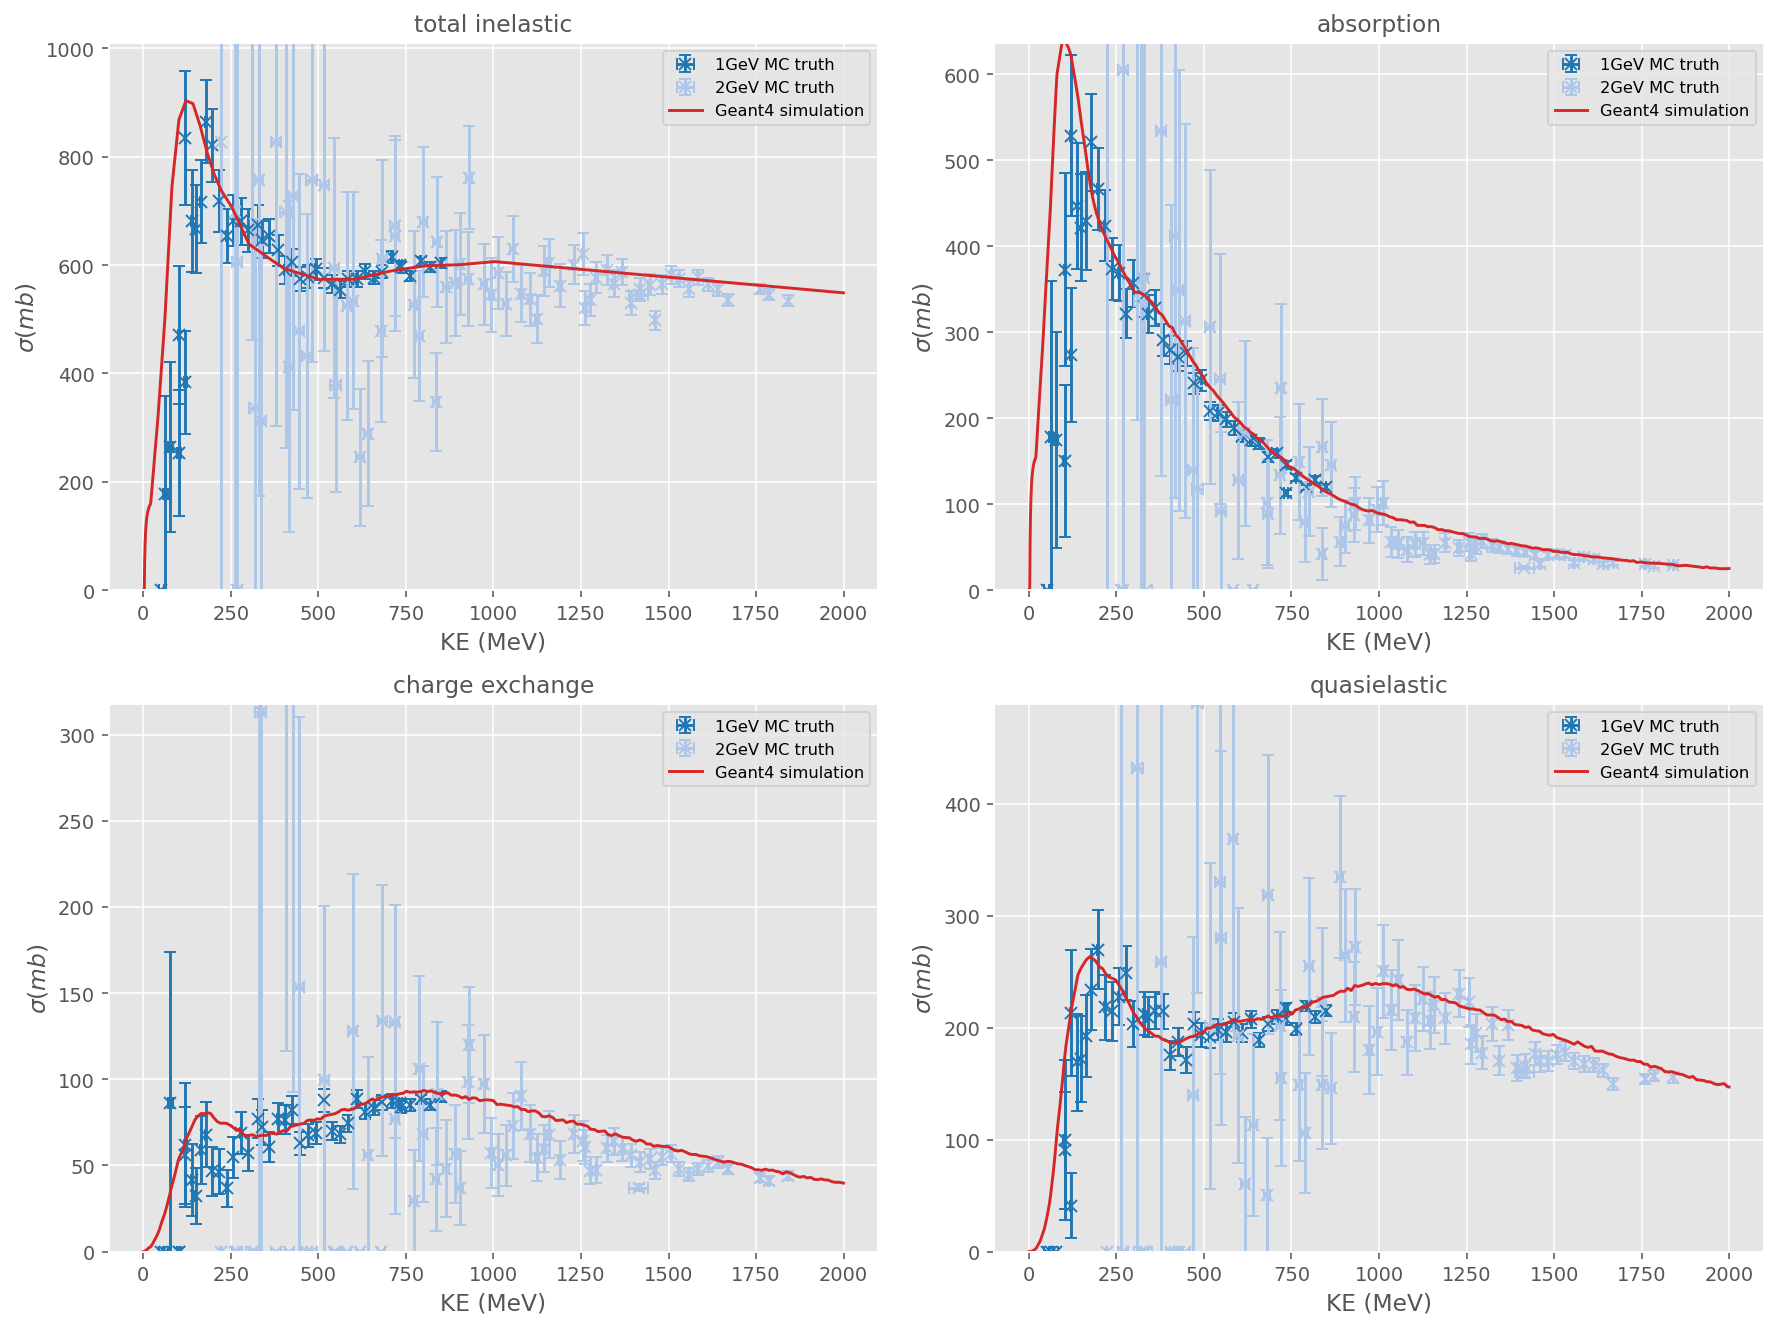

In [152]:
t_xs = {s: ThinSliceResults(samples[s], spatial_slices, regions[s]) for s in samples}
t_e = {s : ThinSliceMeanEnergy(samples[s], spatial_slices, regions[s]) for s in samples}

for i, r in Plots.IterMultiPlot(regions["1GeV"], True, False):
    print(i, r)
    for s in samples:
        Plots.Plot(t_e[s][0][1:-1], t_xs[s][r][0][1:-1], yerr = t_xs[s][r][1][1:-1], xerr = t_e[s][1][1:-1], xlabel = "average $\pi^{+}$ kinetic energy before interacting (MeV)", ylabel = "$\sigma$(mb)", linestyle = "", marker = "x", newFigure = False, label = s + " MC truth")
    cross_sections.Plot(r, label = "Geant4 simulation", color = "C6")
    plt.ylim(0, 0.7 * max(t_xs[s][r][0][1:-1]))

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:154: RuntimeWarning: invalid value encountered in sqrt
  beta = (1 - (1/gamma)**2)**0.5
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/tmp/ipykernel_18833/4056152503.py:300: RuntimeWarning: invalid value encountered in divide
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section
/tmp/ipykernel_18833/4056152503.py:300: RuntimeWarning: invalid value encountered in log
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section
/tmp/ipykernel_18833/4056152503.py:303: RuntimeWarning: invalid value encountered in divide
  v_interact = n_interact*(1- (n_interact/n_incident)) # binomial uncertainty
/tmp/ipykernel_18833/4056152503.py:305: RuntimeWarning: divide by zero encountered in divide
  xs_e

0 total_inelastic

1 absorption

2 charge_exchange

3 quasielastic

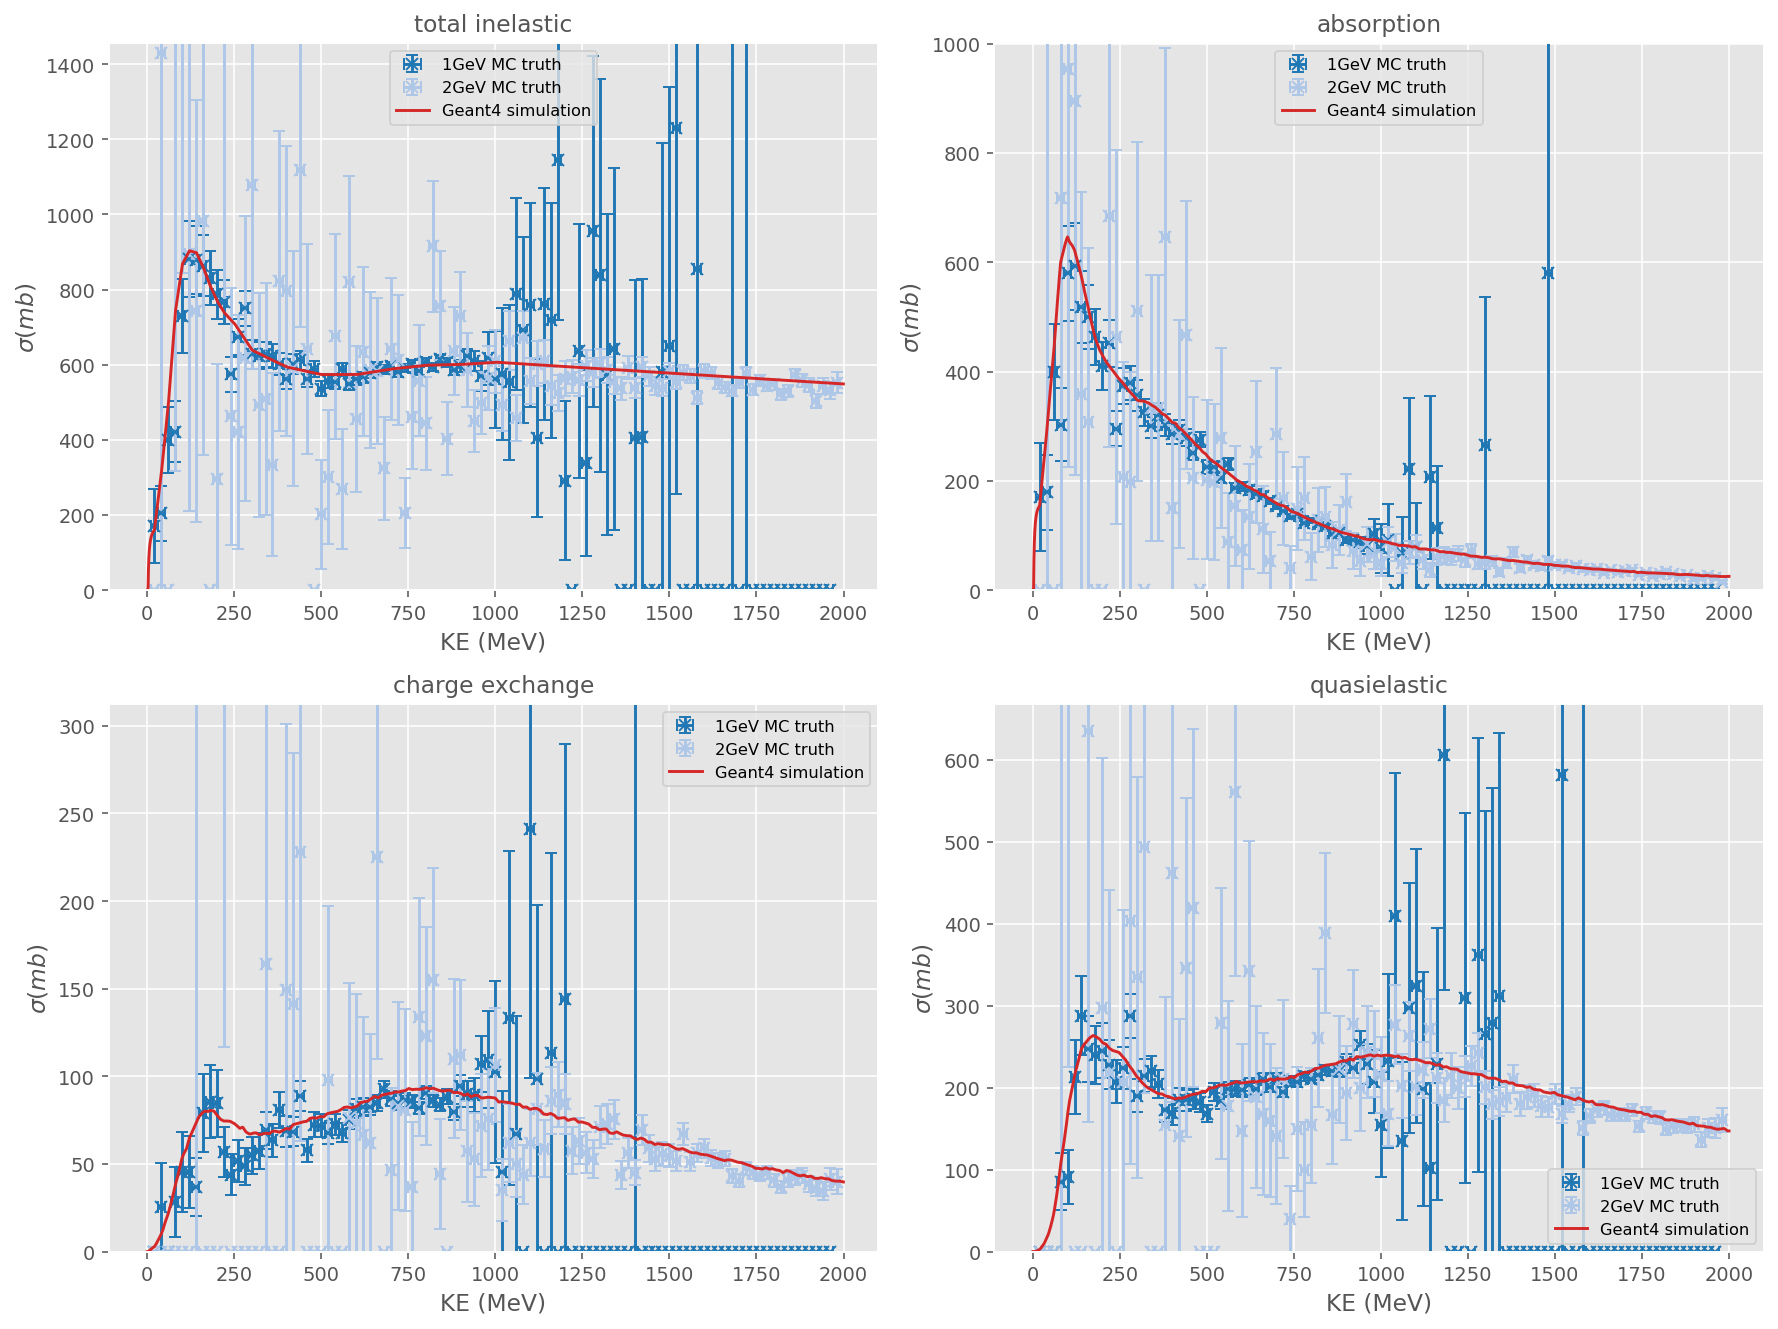

In [153]:
e_xs = {s: EnergySliceResults(samples[s], spatial_slices, regions[s]) for s in samples}

for i, r in Plots.IterMultiPlot(regions["1GeV"], True, False):
    print(i, r)
    for s in samples:
        Plots.Plot(spatial_slices.pos[1:], e_xs[s][r][0][1:], yerr = e_xs[s][r][1][1:], xerr = spatial_slices.width/2, xlabel = "average $\pi^{+}$ kinetic energy before interacting (MeV)", ylabel = "$\sigma$(mb)", linestyle = "", marker = "x", newFigure = False, label = s + " MC truth")
    cross_sections.Plot(r, label = "Geant4 simulation", color = "C6")
    plt.ylim(0, 0.7 * max(e_xs[s][r][0][1:]))

Create thin slices:
 - get all energy depositions made in the collection plane by the beam particle (in Analyser this is view2_IDEs)
 - get the wire pitch in the collection plane (this should be fixed)
 - slice the IDEs by the wire pitch:
   ```c++    
      std::map<int, std::vector<const sim::IDE*>> results; // create a map of slide ID numbers and the ides which fall into this slice

      for (size_t i = 0; i < ides.size(); ++i) {
         int slice_num = std::floor((ides[i]->z - (the_z0 - the_pitch/2.)) / the_pitch); // calculate the slice number for this IDE
         results[slice_num].push_back(ides[i]); // push the IDE into it's relevant slice
   ```
   The formula for calculating the slice number is
   $$
      slice\_num = floor\left(\frac{ide_{z} - z_{0} - \frac{1}{2}pitch}{pitch}\right)
   $$

Create thin tragets:
 - get the initial kinetic energy of the beam particle:
   $$
      KE_{ini} = \sqrt(p^{2} + m^{2}) - m;
   $$
   this is calculated in two ways (for some reason):
   ```c++
     double init_KE = sqrt(1.e6 * true_beam_startP*true_beam_startP +
                        true_beam_mass*true_beam_mass) - true_beam_mass;
   ```
   This uses simb:MCParticle properties
   ```c++
   init_KE = 1.e3 * true_beam_trajectory.E(i-1) - true_beam_mass;
   ```
   This uses the energy in the trajectory point before the first ide in the first slice.
 - loop thorugh all slices
 - calculate the energy deposited in this slice by summing energies of all ides in this slice
 - calculate the incidient energy in this slice, the first incident energy is $KE_{ini}$:
   $$
      KE_{inc, i} = KE_{inc, i-1} - \delta E_{i}
   $$

# Deconvolution/Convolution

Deconvolution (my preference is actually to call this convolution) in this context is used to see whether the discrepancy in the cross section measurement for the thin slice method is because of the spread due to the beam momentum, or some other effect (like statistics). The cross section from simulation is a function of kinetic energy, $\sigma(T_{\pi})$, but the cross section from the thin slice method is a function of average kinetic energy in a thin slice $\sigma(\left<T_{pi}\right>)$. So it is possible the thin slice method implemented in MC truth will not converge to the simulation curve because intrinsically it is not a direct relationship of cross section and kinetic energy, rather, it is convoluted by spread in the kinetic energy at each thin slice. The spread in Kinetic energy in a thin slice is partially due to the spread in the beam momentum i.e. if all particles in the simulation started at with the same momenta, they should have the same energy at each given position.

To test if this is the case, one can either:
 1. deconvolute the results from MC truth i.e. remove the Gaussian smearing bought about by the beam momentum spread. This is essentially unfolding the results and can be tricky.
 2. deconvlute (or I would say convolute) the simulation curve with the beam momentum spread.  

Picking option 2, the convolution of functions f and g, $f*g$ within a finite range ${0, T}$ is:

$$
(f*g)(t) = \int^{T}_{0}f(\tau)g(t-\tau)d\tau
$$

the integral can be done numerically, but the functions themselves must be determined. $g$ can be inferred from the distribution of true kinetic energy at the beam i.e. `events.trueparticles.StartE - particles.from_pdgid(211).mass`. $f$ is the function which produces the simulation curve, however, this is not readly known because the total cross section for LAr are interpolated from results from experimets using different materials, then the exclusive channels are extracted from the Bertini cascade model in Geant. So, in place of $f$ I use linear interpolation of the simulation points, perhaps an empirical formula would suffice.

In [46]:
class square_function:
    def __init__(self, width : float, center : float, scale : float = 1):
        self.l = width
        self.x0 = center
        self.a = scale
        return
    def __call__(self, x : any) -> any:
        return np.where((x > (self.x0 - (self.l/2))) & (x < (self.x0 + (self.l/2))), self.a, 0)

class sawtooth:
    def __init__(self, gradient, center, intercept):
        self.m = gradient
        self.x0 = center
        self.c = intercept
        return
    def __call__(self, x : any) -> any:
        left = self.m * (x - self.x0) + self.c
        right = -self.m * (x - self.x0) + self.c

        y = np.where(left >= self.c, right, left)
        y = np.where(left < 0, 0, y)
        y = np.where(right < 0, 0, y)
        return y

class half_sawtooth:
    def __init__(self, gradient, center, intercept):
        self.m = gradient
        self.x0 = center
        self.c = intercept
        return
    def __call__(self, x : any) -> any:
        y = self.m * (x - self.x0) + self.c
        y = np.where(y < 0, 0, y)
        y = np.where(y > self.c, 0, y)
        return y

class gaussian_pdf:
    def __init__(self, mu : float, sigma : float) -> None:
        self.mu = mu
        self.sigma = sigma
        return
    def __call__(self, x : any) -> any:
        coefficient = 1 / (self.sigma * np.sqrt(2 * np.pi))
        exponent = -(x - self.mu) ** 2 / (2 * self.sigma ** 2)
        return coefficient * np.exp(exponent)

def Convolve(x : np.array, f : callable, g : callable, integral_range : list, nsteps : int) -> np.array:
    """ performs convolution using numerical intergration for a function f and kernel g.

    Args:
        x (np.array): x points
        f (callable): function to convolute
        g (callable): kernel function
        integral_range (list): range of the integral
        nsteps (int): number of steps to use in the integration

    Returns:
        np.array: convoluted function
    """
    if nsteps < len(x):
        print("nsteps should be larger or at least the same size as x")
    t = np.linspace(*integral_range, nsteps)
    h = []
    for i in x:
        h.append(np.trapz(f(t) * g(i - t), t)) # replace with more accurate algorithm?
    return np.array(h)


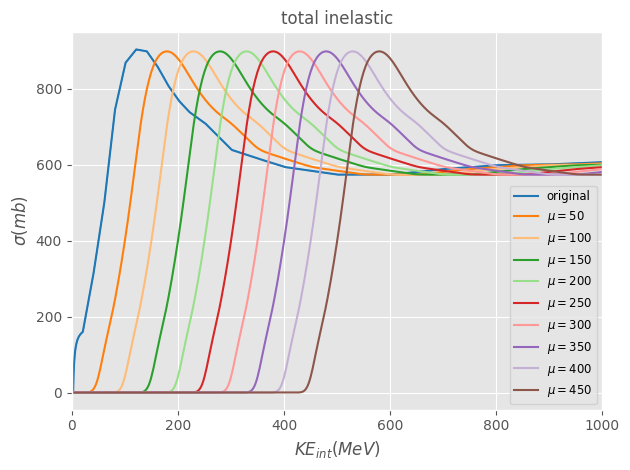

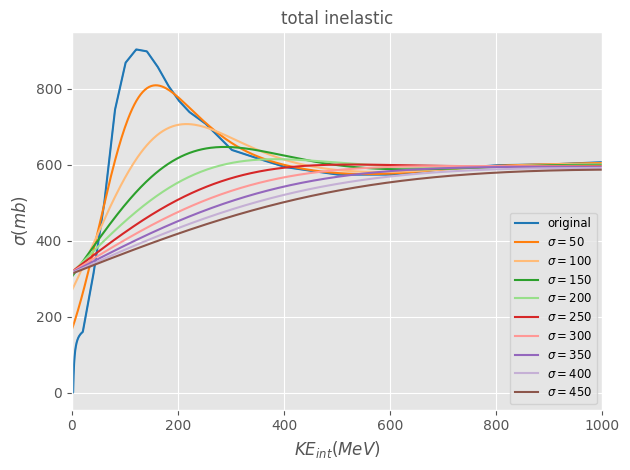

In [47]:
# use a normalised Gaussian to ensure the convulted function has the correct amplitude
def gaussian_pdf(x, mean, std_dev):
    coefficient = 1 / (std_dev * np.sqrt(2 * np.pi))
    exponent = -(x - mean) ** 2 / (2 * std_dev ** 2)
    return coefficient * np.exp(exponent)

def CrossSectionConvolution(xs : cross_section.GeantCrossSections, channel : str, mu : float, sigma : float, int_step : float = 10, conv_step : float = 10, energy_range : list = [0, 1000], label : str = None) -> tuple[np.array, np.array]:
    """ test function to convolute a cross section curve with some gaussian functions.

    Args:
        xs (cross_section.GeantCrossSections): geant cross sections
        channel (str): cross section channel to study
        mu (float): mean of gaussian
        sigma (float): rms of gaussian
        int_step (float, optional): integration step size. Defaults to 10.
        conv_step (float, optional): convolution step size. Defaults to 10.
        energy_range (list, optional): energy range to study. Defaults to [0, 1000].
        label (str, optional): plot label. Defaults to None.

    Returns:
        tuple[np.array, np.array]: _description_
    """
    def f(x, t): # integrand
        return p(x) * gaussian_pdf(t - x, mu, sigma)

    sampling_range = [min(xs.KE), max(xs.KE)]
    points = np.arange(*sampling_range, int_step)
    p = interp1d(xs.KE, getattr(xs, channel)) # interpolate between xs values here.

    h = []
    x = np.arange(*energy_range, conv_step)
    for t in x:
        s = np.trapz(f(points, t), points)
        h.append(s)
    Plots.Plot(x, h, newFigure = False, label = label)
    plt.xlim(*energy_range)
    return x, h

cross_sections = cross_section.GeantCrossSections()

values = np.arange(50, 500, 50)
plt.figure()
cross_sections.Plot("total_inelastic", label = "original")
for v in values:
    _ = CrossSectionConvolution(cross_sections, "total_inelastic", v, 10, conv_step = 2, label = "$\mu=$" + str(v))
plt.figure()
cross_sections.Plot("total_inelastic", label = "original")
for v in values:
    _ = CrossSectionConvolution(cross_sections, "total_inelastic", 0, v, conv_step = 2, label = "$\sigma=$" + str(v))


### Beam momentum

In [48]:
true_beam_KE = np.array(events.trueParticles.energy[:, 0] - Particle.from_pdgid(211).mass)

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in power
  result = getattr(ufunc, method)(


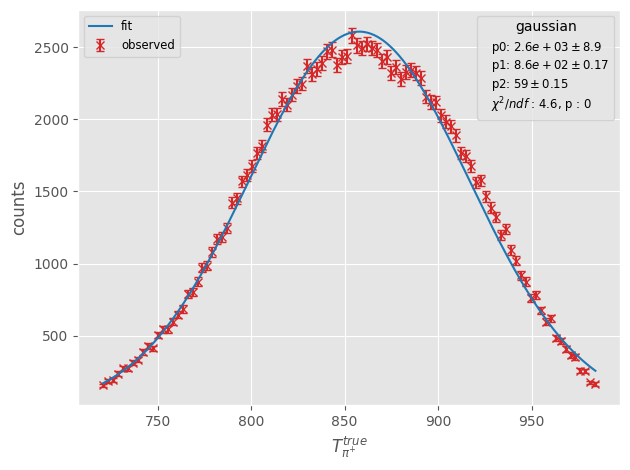

In [49]:
h, edges = np.histogram(np.array(true_beam_KE[~np.isnan(true_beam_KE)]), bins = 100, range = sorted([np.nanpercentile(true_beam_KE, 1), np.nanpercentile(true_beam_KE, 99)]))
popt, _ = Fitting.Fit((edges[1:] + edges[:-1]) / 2, h, np.sqrt(h), Fitting.gaussian, plot = True, xlabel = "$T^{true}_{\pi^{+}}$", ylabel = "counts")

# expteced_peak = (1000**2 - Particle.from_pdgid(211).mass**2)**0.5 - Particle.from_pdgid(211).mass # beam should be 1000 MeV pions, so, should be centred at ~850 MeV KE.
# plt.axvline(expteced_peak, color = "black", linestyle = "--")

In [54]:
regions = truth_regions(events)
xs = ThinSliceResults(events, cross_section.Slices(10, -10, 720), regions)
e = ThinSliceMeanEnergy(events, cross_section.Slices(10, -10, 720), regions)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:695: RuntimeWarning: invalid value encountered in divide
  mean_energy = sum_energy / counts
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:697: RuntimeWarning: invalid value encountered in divide
  std_energy = np.divide(sum_energy_sqr, counts) - mean_energy**2


In [66]:
cross_sections = cross_section.GeantCrossSections()
p = interp1d(cross_sections.KE, cross_sections.total_inelastic)
KE_v = np.linspace(1, 1001, 100)
h = Convolve(cross_sections.KE, p, gaussian_pdf(0, 0, popt[2]), [min(cross_sections.KE), max(cross_sections.KE)], len(cross_sections.KE))
h_2 = Convolve(cross_sections.KE, p, gaussian_pdf(8.5, 0, popt[2]), [min(cross_sections.KE), max(cross_sections.KE)], len(cross_sections.KE))

plt.figure()
cross_sections.Plot("total_inelastic", label = "original")
Plots.Plot(cross_sections.KE, h, label = "$\mu = $" + str(0) + ", $\sigma =$" + str(popt[2]), newFigure = False)
# Plots.Plot(cross_sections.KE, h_2, label = "$\mu = $" + str(8.5) + ", $\sigma =$" + str(popt[2]), newFigure = False)
Plots.Plot(e[0][1:-1], xs["total_inelastic"][0][1:-1], yerr = xs["total_inelastic"][1][1:-1], xerr = e[1][1:-1], marker = "x", linestyle = "", label = "MC truth", newFigure = False)

plt.xlim(0, 1050)


TypeError: 'numpy.float64' object is not callable

# Position vs Energy

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:695: RuntimeWarning: invalid value encountered in divide
  mean_energy = sum_energy / counts
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:697: RuntimeWarning: invalid value encountered in divide
  std_energy = np.divide(sum_energy_sqr, counts) - mean_energy**2


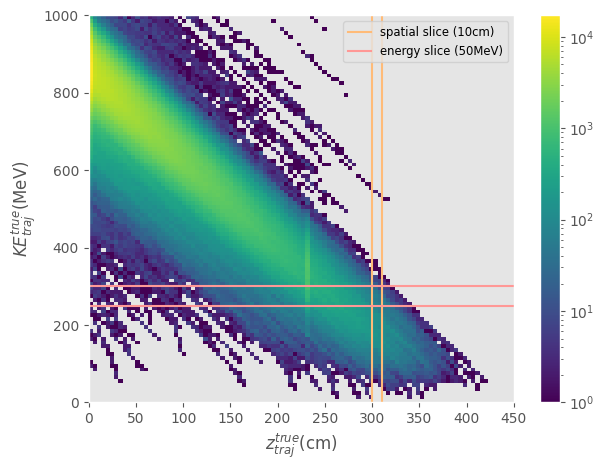

In [57]:
traj_KE = events.trueParticles.beam_traj_KE[:, :-1] # get beam particle kinetic energy at each trajectory point from simulation
traj_pos = events.trueParticles.beam_traj_pos.z[:, :-1] # get beam particle z at each trajectory point from simulation 

regions = truth_regions(events) # get trtuh regions
mean_slice_energy, mean_error_slice_energy = cross_section.ThinSlice.MeanSliceEnergy(traj_KE[regions["total_inelastic"]], traj_pos[regions["total_inelastic"]], spatial_slices) # get average particle energy in each slice

Plots.PlotHist2D(ak.ravel(traj_pos[regions["total_inelastic"]]), ak.ravel(traj_KE[regions["total_inelastic"]]), x_range = [0, 450], y_range = [0, 1000], xlabel = "$z^{true}_{traj}$(cm)", ylabel = "$KE^{true}_{traj}$(MeV)")

plt.axvline(300, color = "C3")
plt.axvline(310, color = "C3", label = "spatial slice (10cm)")

plt.axhline(250, color = "C7")
plt.axhline(300, color = "C7", label = "energy slice (50MeV)")

plt.legend(loc = "upper right")

In [90]:
import matplotlib.backends.backend_pdf


with matplotlib.backends.backend_pdf.PdfPages("thin_slice_xs_bins.pdf") as pdf:
    xs_func = interp1d(cross_sections.KE, cross_sections.total_inelastic, fill_value = "extrapolate")
    # for i, s in Plots.IterMultiPlot(list(slices)):
    for i, s in enumerate(list(spatial_slices)):
        mask = spatial_slices.pos_to_num(traj_pos[regions["total_inelastic"]][:, -1]) == s.num
        energy = traj_KE[regions["total_inelastic"]][:, -1][mask]
        Plots.PlotHist(xs_func(ak.ravel(energy)), title = s.__str__(), range = [150, 900], xlabel = "$\sigma$(mb)")
        pdf.savefig()
        plt.close()

with matplotlib.backends.backend_pdf.PdfPages("thin_slice_KE_int_bins.pdf") as pdf:
    for i, s in enumerate(list(spatial_slices)):
        mask = spatial_slices.pos_to_num(traj_pos[regions["total_inelastic"]][:, -1]) == s.num
        energy = traj_KE[regions["total_inelastic"]][:, -1][mask]

        Plots.PlotHist(ak.ravel(energy), title = s.__str__(), range = [0, 1100], xlabel = "$KE^{true}_{int}$ (MeV)")
        pdf.savefig()
        plt.close()

In [78]:
energies = []
traj_slice = spatial_slices.pos_to_num(traj_pos[regions["total_inelastic"]])
for s in spatial_slices:
    mask = traj_slice == s.num
    energy = traj_KE[regions["total_inelastic"]][mask]
    energies.append(np.mean(energy))
energies.pop(-2)
energies = np.array(energies)

m, e = cross_section.ThinSlice.MeanSliceEnergy(traj_KE[regions["total_inelastic"]], traj_pos[regions["total_inelastic"]], spatial_slices)
print(m - energies)

/tmp/ipykernel_19024/976811188.py:250: RuntimeWarning: invalid value encountered in divide
  mean_energy = sum_energy / counts
/tmp/ipykernel_19024/976811188.py:252: RuntimeWarning: invalid value encountered in divide
  std_energy = np.sqrt(np.divide(sum_energy, counts) - mean_energy**2)
/tmp/ipykernel_19024/976811188.py:252: RuntimeWarning: invalid value encountered in sqrt
  std_energy = np.sqrt(np.divide(sum_energy, counts) - mean_energy**2)
/tmp/ipykernel_19024/976811188.py:254: RuntimeWarning: invalid value encountered in divide
  error_mean_energy = np.divide((sum_energy_sqr)**0.5, counts)


[ 3.41060513e-13  1.55523594e-10  1.19371180e-11 -3.63797881e-12
  1.81898940e-12  1.58024704e-11 -4.77484718e-12 -1.09139364e-11
  4.54747351e-12  1.31876732e-11 -1.18234311e-11  8.07176548e-12
  1.96678229e-11 -6.48014975e-12 -7.50333129e-12  5.34328137e-12
 -2.48974175e-11  2.39310793e-11  2.21689334e-12 -1.79056769e-11
 -1.58024704e-11 -3.80850906e-12 -1.92699190e-11  8.44124770e-11
 -9.89643922e-11  1.38356882e-10 -2.80806489e-11 -1.50976120e-10
  1.31024080e-11  1.30199851e-10 -2.01708872e-10  2.63156608e-10
 -3.33983508e-10  3.10933501e-10 -4.69015049e-10 -5.31343858e-10
  8.33324520e-10  1.25154997e-10 -7.57593455e-09  1.76730168e-08
 -2.00680574e-08  2.25942784e-08             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
  6.42330633e-11]

# Closure Test

In [9]:
pdf = Plots.PlotBook("closure_test_2GeV_full.pdf", False)

In [21]:
def ClosureTest(process = "total_inelastic", ylim = 1000, xlim = [0, 1000]):
    # Plot true spatial slice cross section
    # Plot energy slice cross section, but use true initial energy and reco track length
    true_mean_energy = cross_section.ThinSlice.MeanSliceEnergy(events.trueParticles.beam_traj_KE[:, -2][regions["total_inelastic"]], events.trueParticles.beam_traj_pos.z[:, -2][regions["total_inelastic"]], spatial_slices)

    output_spatial_slice = ThinsliceCrossSection(events.trueParticles.beam_traj_pos.z[:, -1], regions[process], spatial_slices)
    output_energy_slice = ESliceCrossSection(events.trueParticles.beam_traj_KE[:, -2], events.trueParticles.beam_KE_front_face, regions[process], ~in_tpc, energy_slices, Particle.from_pdgid(211))
    output_energy_slice_bb = ESliceCrossSection(true_KE_int_bb, events.trueParticles.beam_KE_front_face, regions[process], ~in_tpc, energy_slices, Particle.from_pdgid(211))

    cross_sections.Plot(process)
    Plots.Plot(true_mean_energy[0][1:-1], output_spatial_slice["xs"][1:-1], xerr = true_mean_energy[1][1:-1], yerr = output_spatial_slice["xs_err"][1:-1], label = "spatial slice", marker = "x", linestyle = "", newFigure = False)
    Plots.Plot(energy_slices.pos, output_energy_slice_bb["xs"], xerr = energy_slices.width / 2, yerr = output_energy_slice_bb["xs_err"], label = "energy slice, bethe bloch", marker = "x", linestyle = "", newFigure = False)
    plt.ylim(0, ylim)
    plt.xlim(xlim)
    pdf.Save()

    dim = Plots.FigureDimensions(2)
    plt.subplots(figsize = [6.4 * dim[1], 4.8 * dim[0]])
    plt.subplot(dim[0], dim[1], 1)
    cross_sections.Plot(process)
    Plots.Plot(true_mean_energy[0][1:-1], output_spatial_slice["xs"][1:-1], xerr = true_mean_energy[1][1:-1], yerr = output_spatial_slice["xs_err"][1:-1], label = "spatial slice", marker = "x", linestyle = "", newFigure = False)
    plt.ylim(0, ylim)
    plt.xlim(xlim)

    plt.subplot(dim[0], dim[1], 2)
    cross_sections.Plot(process)
    Plots.Plot(energy_slices.pos, output_energy_slice_bb["xs"], xerr = energy_slices.width / 2, yerr = output_energy_slice_bb["xs_err"], label = "energy slice, bethe bloch", marker = "x", linestyle = "", newFigure = False)
    plt.ylim(0, ylim)
    plt.xlim(xlim)
    pdf.Save()

    plt.figure()
    cross_sections.Plot(process)
    # Plots.Plot(true_mean_energy[0][1:-1], output_spatial_slice["xs"][1:-1], xerr = true_mean_energy[1][1:-1], yerr = output_spatial_slice["xs_err"][1:-1], label = "spatial slice", marker = "x", linestyle = "", newFigure = False)
    Plots.Plot(energy_slices.pos, output_energy_slice["xs"], xerr = energy_slices.width / 2, yerr = output_energy_slice["xs_err"], label = "energy slice, $KE^{true}_{int}$", marker = "x", linestyle = "", newFigure = False)
    Plots.Plot(energy_slices.pos, output_energy_slice_bb["xs"], xerr = energy_slices.width / 2, yerr = output_energy_slice_bb["xs_err"], label = "energy slice, $KE_{int, bb}$", marker = "x", linestyle = "", newFigure = False)
    plt.ylim(0, ylim)
    plt.xlim(xlim)
    pdf.Save()

regions = truth_regions(events)
true_KE_int_bb = cross_section.BetheBloch.InteractingKE(events.trueParticles.beam_KE_front_face, events.trueParticles.beam_track_length, 50)

spatial_slices = cross_section.Slices(10, 0, 710)
energy_slices = cross_section.Slices(100, 0, 1000, True)
in_tpc = (events.trueParticles.beam_traj_pos.z[:, -2] > 0) & (events.trueParticles.beam_traj_pos.z[:, -2] < 700)


/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/tmp/ipykernel_86059/512052621.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(dim[0], dim[1], 1)


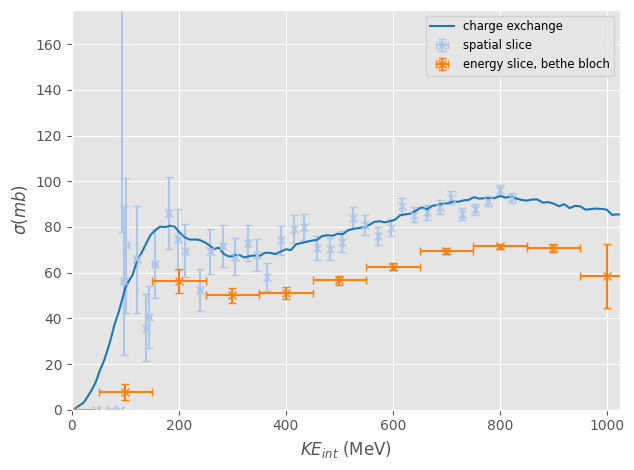

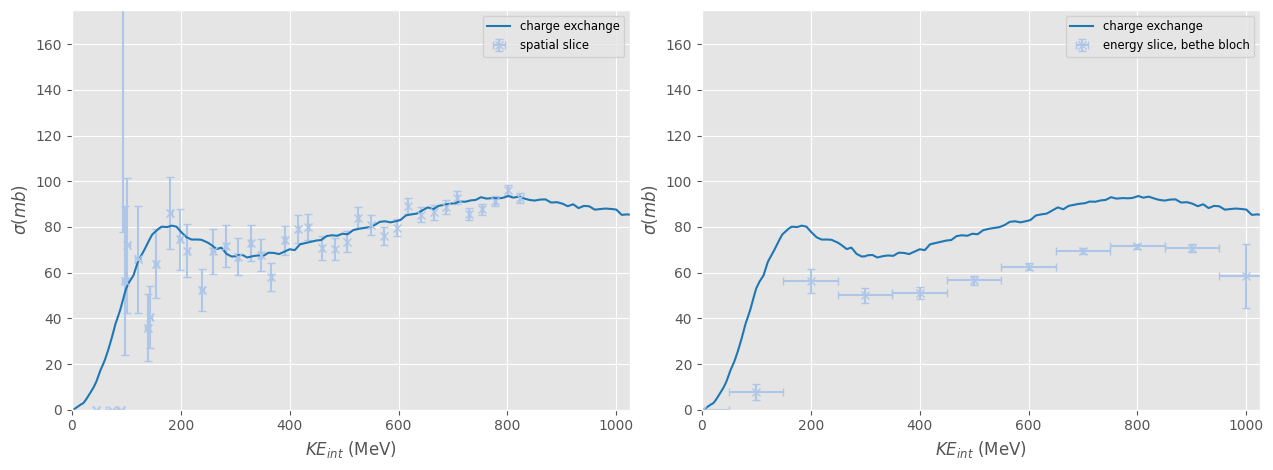

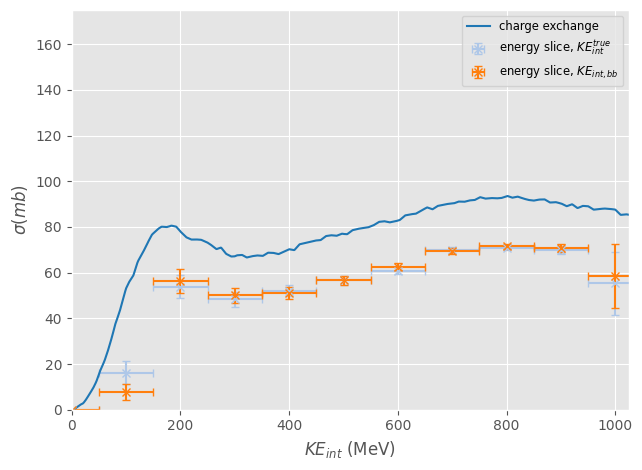

In [22]:
ClosureTest("charge_exchange", 175, [0, 1025])

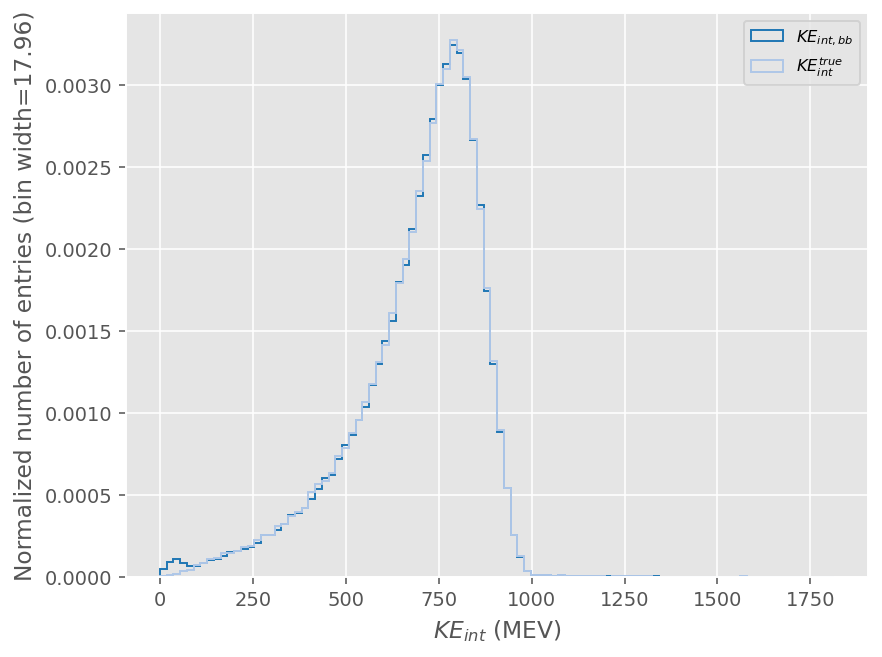

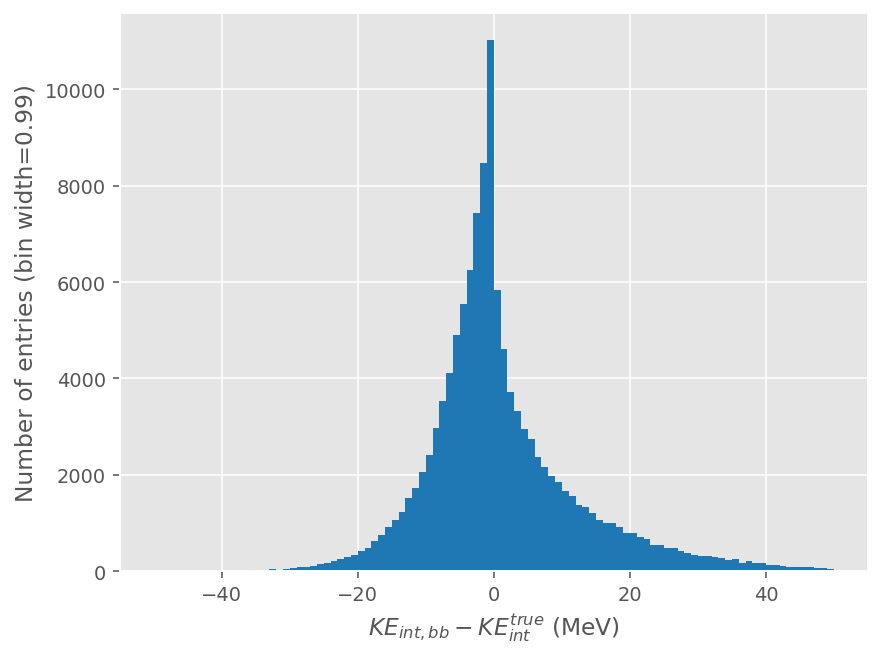

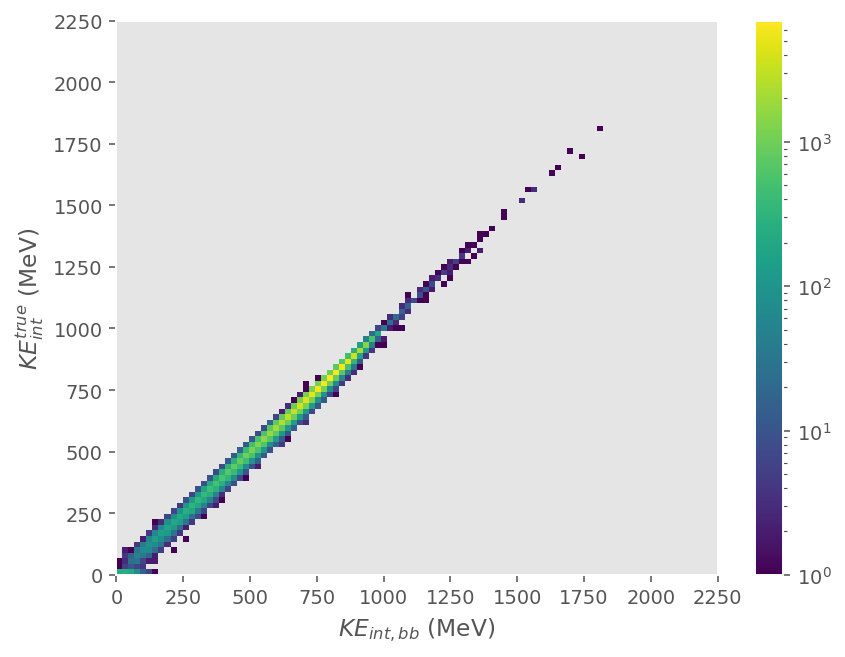

In [38]:
Plots.PlotHistComparison([true_KE_int_bb[in_tpc], events.trueParticles.beam_traj_KE[:, -2][in_tpc]], labels = ["$KE_{int, bb}$", "$KE^{true}_{int}$"], xlabel = "$KE_{int}$ (MEV)", x_range = [0, 2250])
pdf.Save()
Plots.PlotHist(true_KE_int_bb[in_tpc] - events.trueParticles.beam_traj_KE[:, -2][in_tpc], xlabel = "$KE_{int, bb} - KE^{true}_{int}$ (MeV)", range = [-50, 50])
pdf.Save()
Plots.PlotHist2D(true_KE_int_bb[in_tpc], events.trueParticles.beam_traj_KE[:, -2][in_tpc], xlabel = "$KE_{int, bb}$ (MeV)", ylabel = "$KE^{true}_{int}$ (MeV)", x_range = [0, 2250], y_range = [0, 2250])
pdf.Save()

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:673: RuntimeWarning: invalid value encountered in divide
  mean_energy = sum_energy / counts
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:675: RuntimeWarning: invalid value encountered in divide
  std_energy = np.divide(sum_energy_sqr, counts) - mean_energy**2
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:167: RuntimeWarning: invalid value encountered in sqrt
  beta = (1 - (1/gamma)**2)**0.5
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/tmp/ipykernel_105705/2093494813.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(dim[0], dim[1], 1)


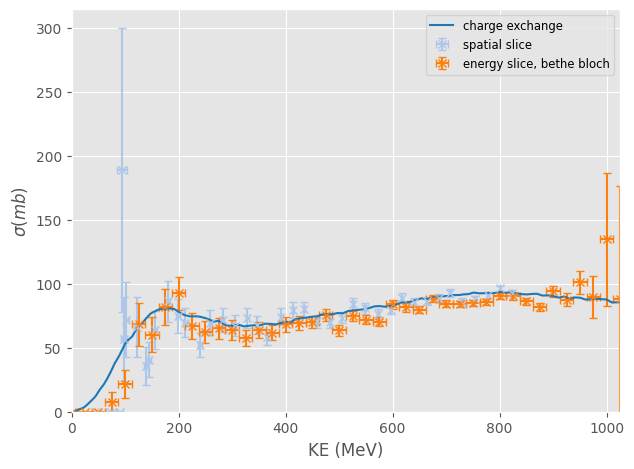

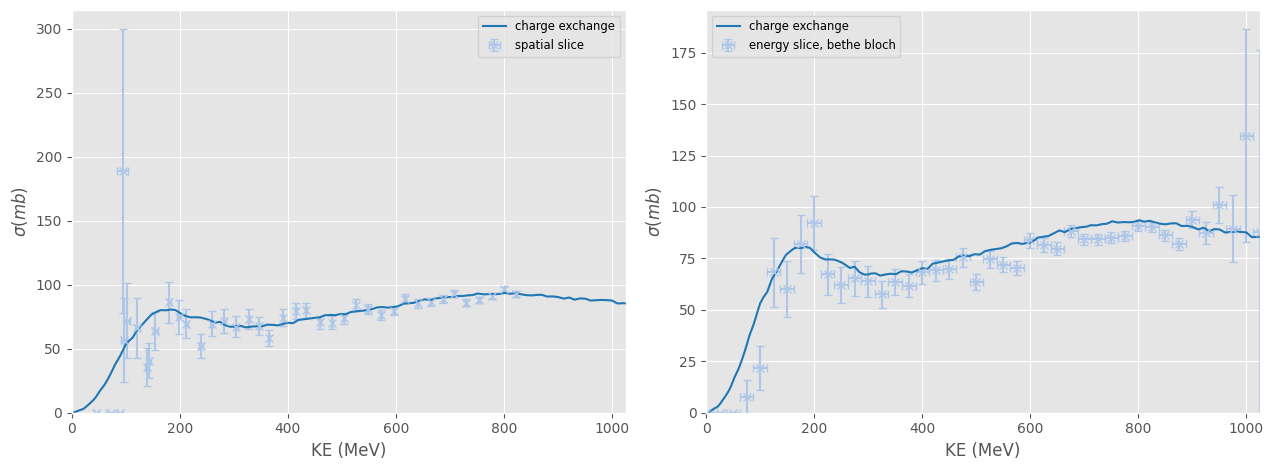

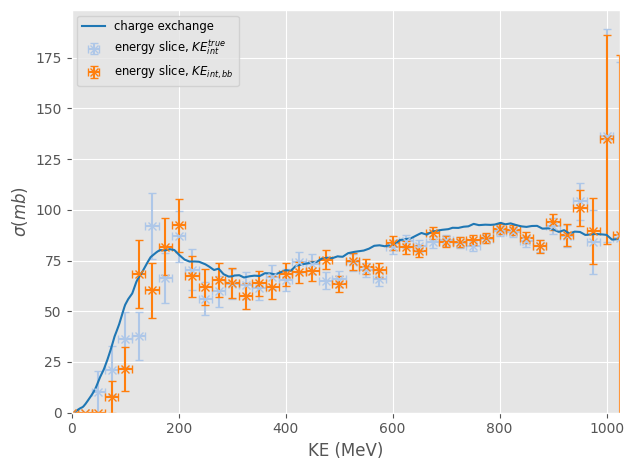

In [15]:
ClosureTest("charge_exchange", None, [0, 1025])

/tmp/ipykernel_85792/733048237.py:140: RuntimeWarning: invalid value encountered in divide
  output["n_interact_err"] = np.sqrt(output["n_interact"]*(1- (output["n_interact"]/output["n_incident"])))
/tmp/ipykernel_85792/733048237.py:151: RuntimeWarning: invalid value encountered in divide
  output["n_interact_err"] = np.sqrt(output["n_interact"]*(1- (output["n_interact"]/output["n_incident"])))
/tmp/ipykernel_85792/1566114596.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(dim[0], dim[1], 1)


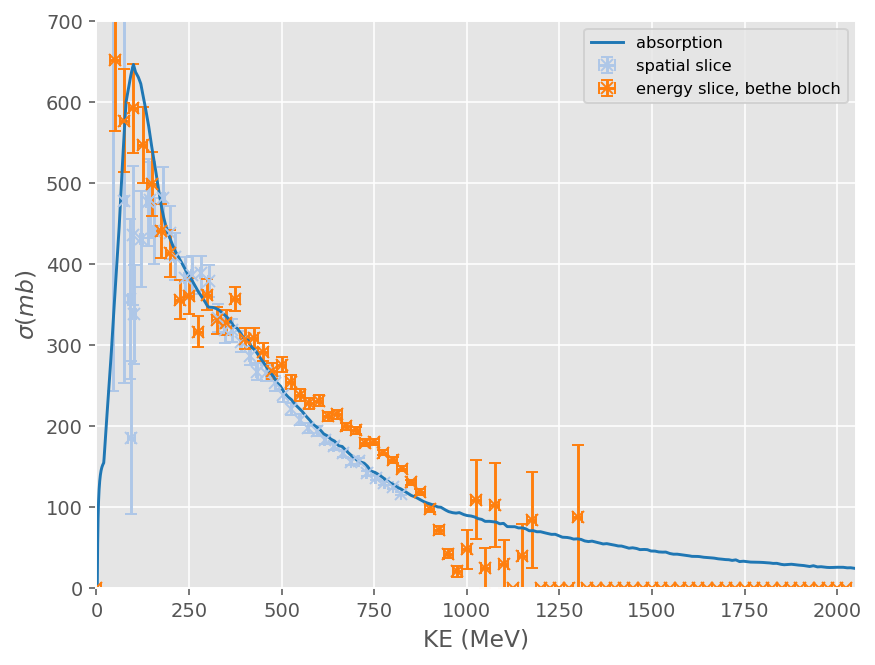

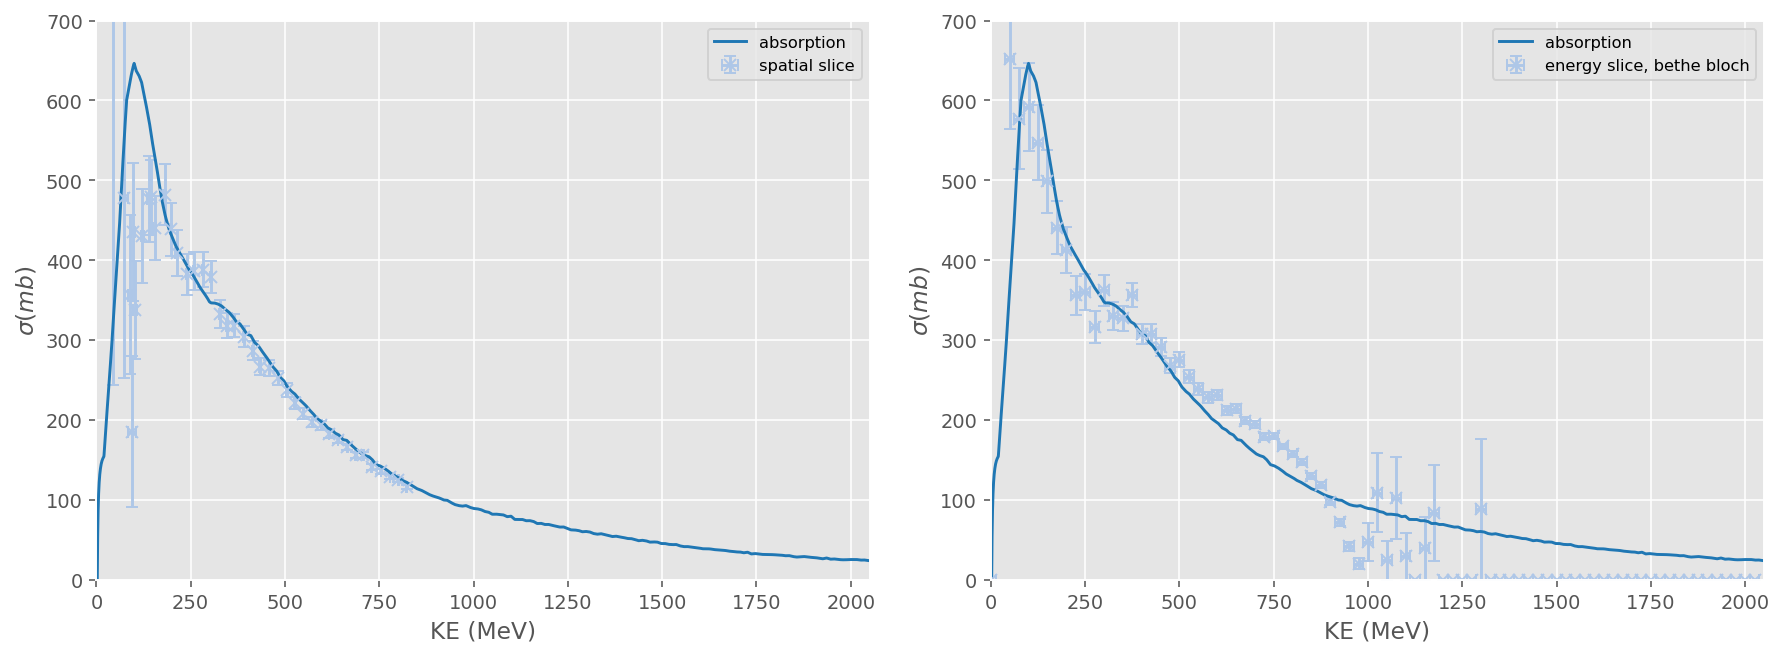

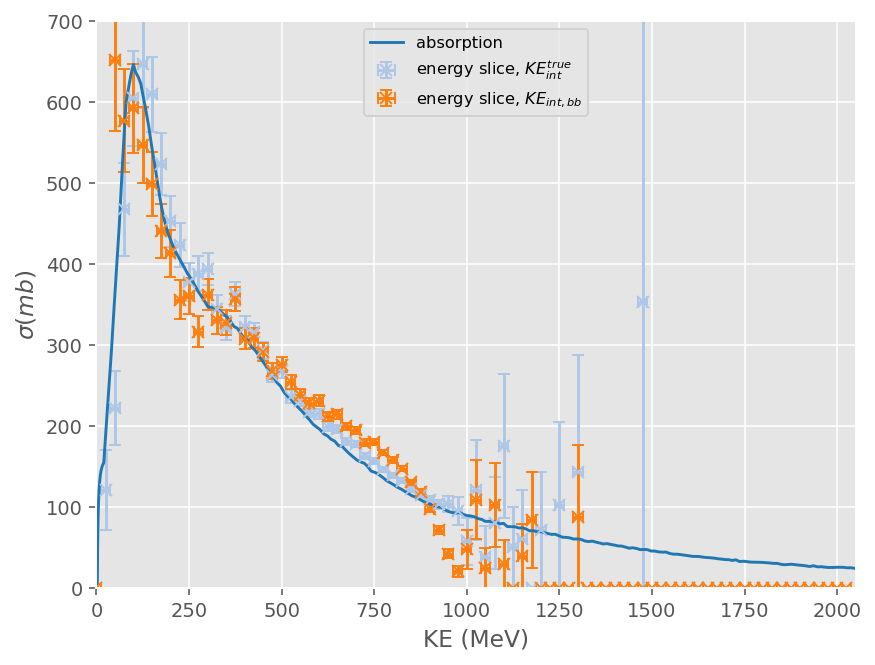

In [20]:
ClosureTest("absorption", 700, [0, 2050])

/tmp/ipykernel_85792/733048237.py:140: RuntimeWarning: invalid value encountered in divide
  output["n_interact_err"] = np.sqrt(output["n_interact"]*(1- (output["n_interact"]/output["n_incident"])))
/tmp/ipykernel_85792/733048237.py:151: RuntimeWarning: invalid value encountered in divide
  output["n_interact_err"] = np.sqrt(output["n_interact"]*(1- (output["n_interact"]/output["n_incident"])))
/tmp/ipykernel_85792/1566114596.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(dim[0], dim[1], 1)


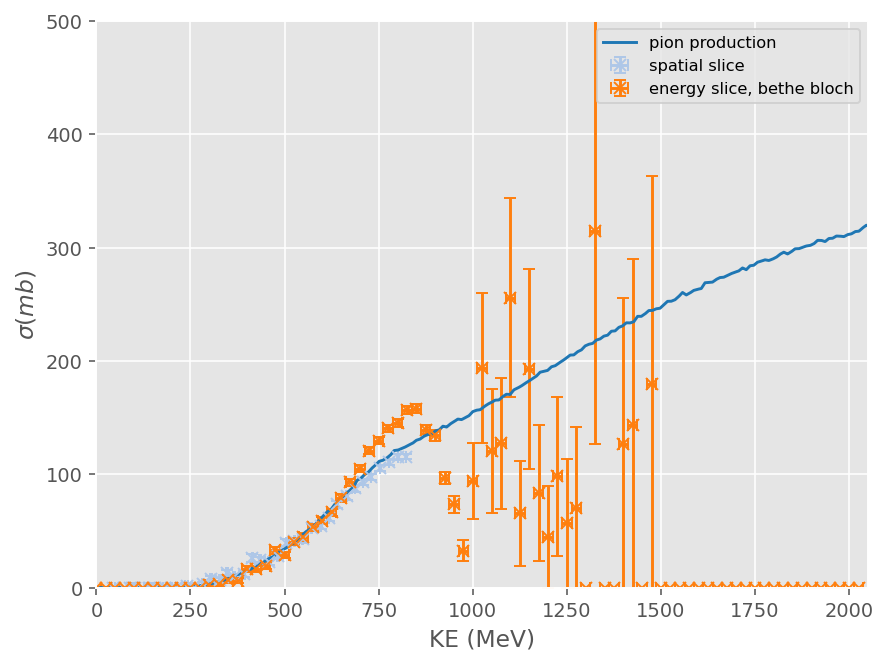

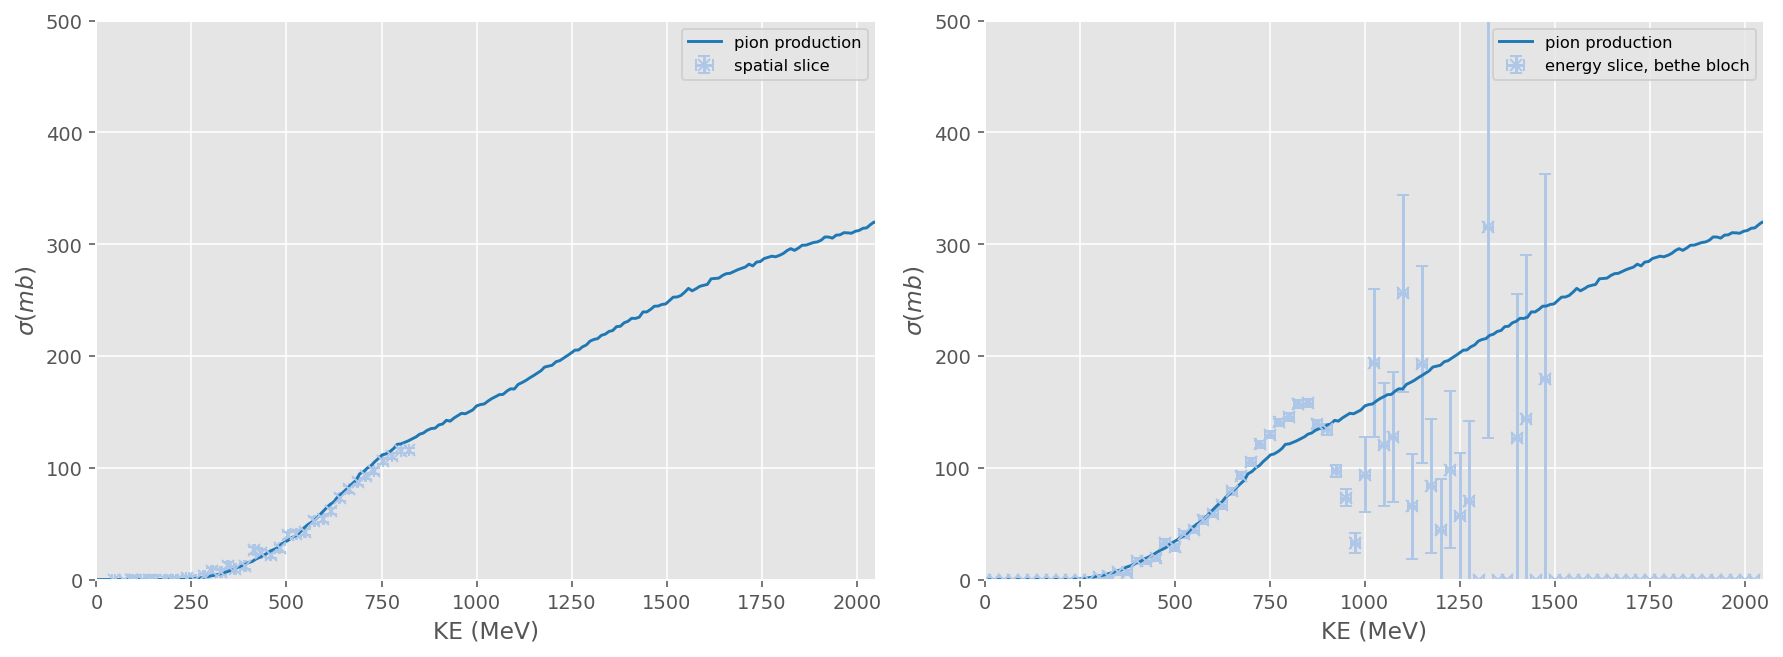

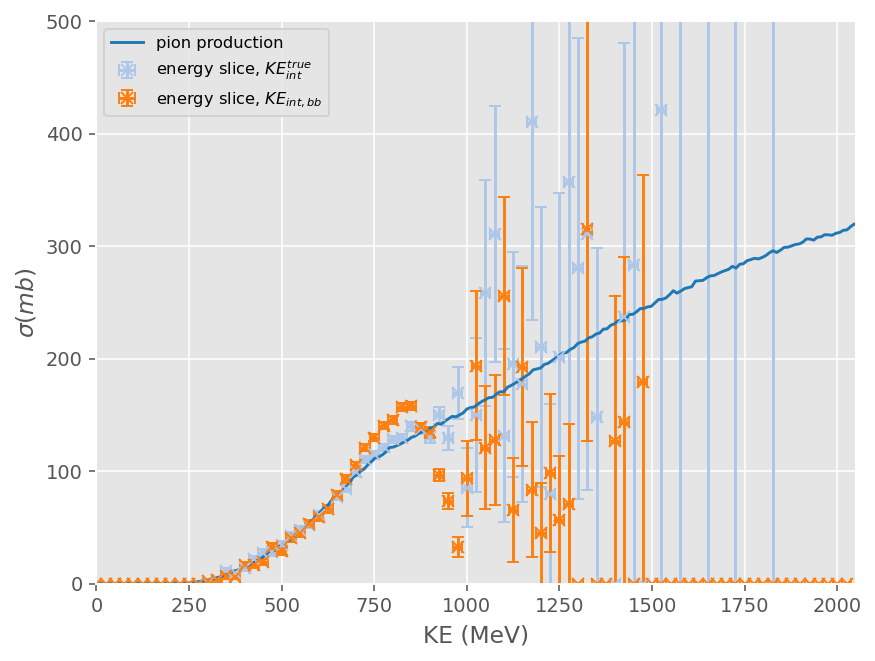

In [21]:
ClosureTest("pion_production", 500, [0, 2050])

In [18]:
pdf.close()

In [4]:
def KE_int_bb_err(KE_init, track_length, n, track_length_err, KE_init_err):
    sigma = KE_init_err
    KE = KE_init
    sum_dEdX = 0
    for i in range(n):
        dEdX = cross_section.BetheBloch.meandEdX(KE, Particle.from_pdgid(211))
        sum_dEdX = sum_dEdX + dEdX
        KE = KE - dEdX * track_length / n
        sigma = (sigma**2 + (sum_dEdX)**2 * (track_length_err/n)**2)**0.5
    KE = ak.where(KE < 0, 0, KE)
    return KE, sigma

KE_int_bb_err(events.trueParticles.beam_KE_front_face, events.trueParticles.beam_track_length, 50, 1, 1)

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in add
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in power
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.1

(<Array [763, 631, 818, 929, ... 735, 925, 958] type='144230 * ?float64'>,
 <Array [9.08, 9.09, 9.15, ... 9.1, 9.21, 9.24] type='144230 * ?float64'>)

# Reco Quantity resolution

In [60]:
def Params(events : Master.Data) -> dict:
    KE_inst = cross_section.KE(events.recoParticles.beam_inst_P, Particle.from_pdgid(211).mass)
    reco_parameter = {
        "end_pos_z" : events.recoParticles.beam_endPos_SCE.z,
        "track_length" : ak.sum(vector.dist(events.recoParticles.beam_calo_pos[:, 1:], events.recoParticles.beam_calo_pos[:, :-1]), -1),
        "KE_ff" : KE_inst - cross_section.UpstreamEnergyLoss(KE_inst, args.upstream_loss_correction_params["value"])
    }
    # reco_parameter["KE_int"] = reco_parameter["KE_ff"] - cross_section.RecoDepositedEnergy(events, reco_parameter["KE_ff"], "bb")
    reco_parameter["KE_int"] = cross_section.BetheBloch.InteractingKE(reco_parameter["KE_ff"], reco_parameter["track_length"], Particle.from_pdgid(211), 50)

    true_parameter = {
        "end_pos_z" : events.trueParticles.beam_traj_pos.z[:, -1],
        "track_length" : events.trueParticles.beam_track_length,
        "KE_ff" : events.trueParticles.beam_KE_front_face,
        "KE_int" : events.trueParticles.beam_traj_KE[:, -2],
    }
    return {"reco" : reco_parameter, "true" : true_parameter}

In [61]:
parameters = Params(events)
reco_parameter = parameters["reco"]
true_parameter = parameters["true"]
print(reco_parameter)
print(true_parameter)

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in power
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(


{
    'end_pos_z': <Array [11.7, 120, -999, ... 47.5, -999, -999] type='144230 * float64'>,
    'track_length': <Array [11.9, 125, 0, 319, ... 0, 49.4, 0, 0] type='144230 * float64'>,
    'KE_ff': <Array [739, 955, 905, 911, ... 836, 897, 909] type='144230 * float64'>,
    'KE_int': <Array [713, 681, 905, 230, ... 728, 897, 909] type='144230 * float64'>
}

{
    'end_pos_z': <Array [11.4, 118, 27.3, ... -46.2, -86.3] type='144230 * float64'>,
    'track_length': <Array [11.5, 122, 27.7, 0, ... 49.2, 0, 0] type='144230 * float64'>,
    'KE_ff': <Array [788, 897, 879, 929, ... 842, 925, 958] type='144230 * ?float64'>,
    'KE_int': <Array [762, 637, 824, 922, ... 745, 921, 958] type='144230 * float64'>
}

In [62]:
pdf = Plots.PlotBook("method_choice.pdf", False)

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


end_pos_z  track_length     KE_ff    KE_int
mean   -0.02126     -0.014454  0.004488 -0.035776
rms     0.27839      0.295893  0.054353  0.202188

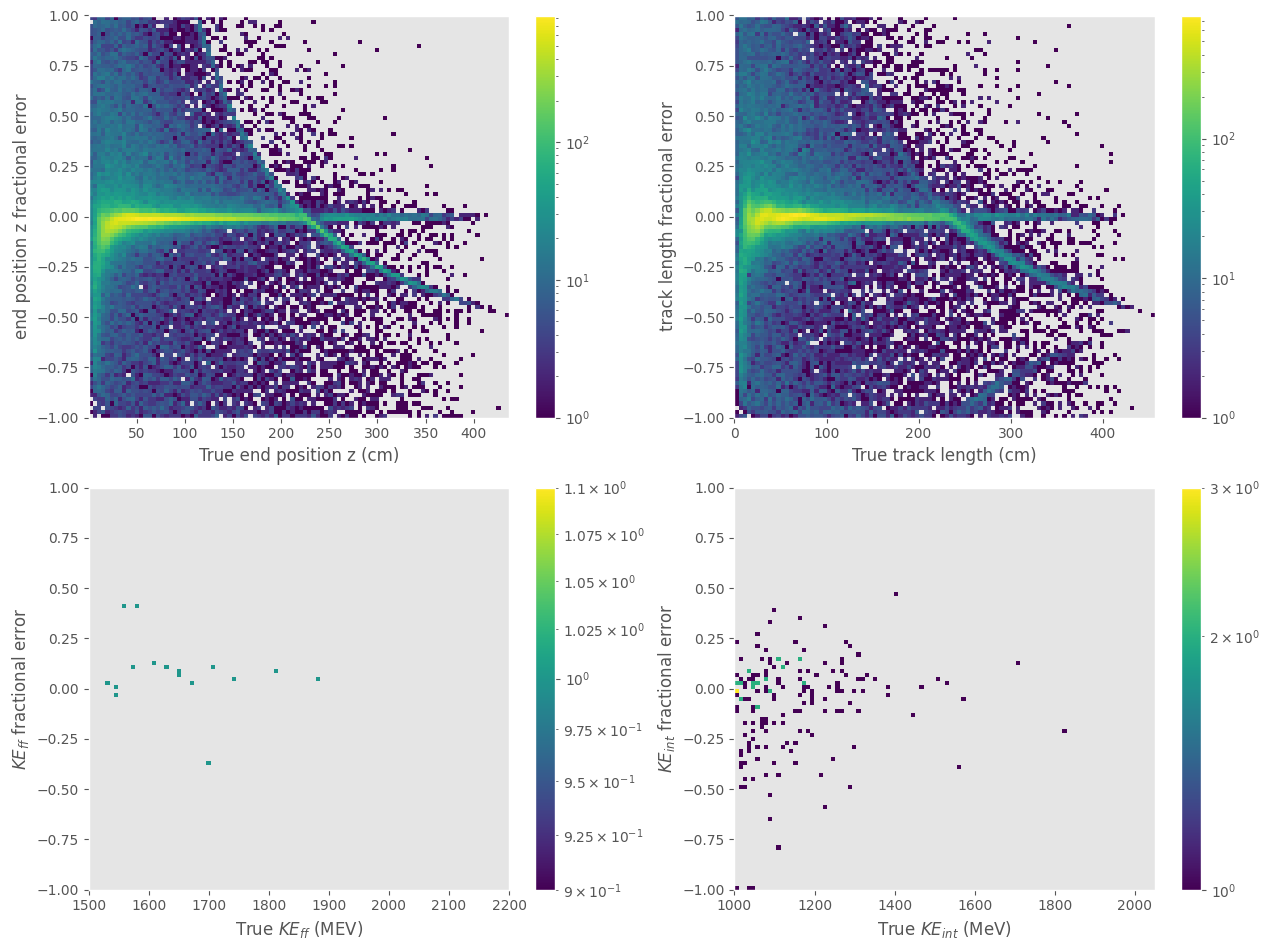

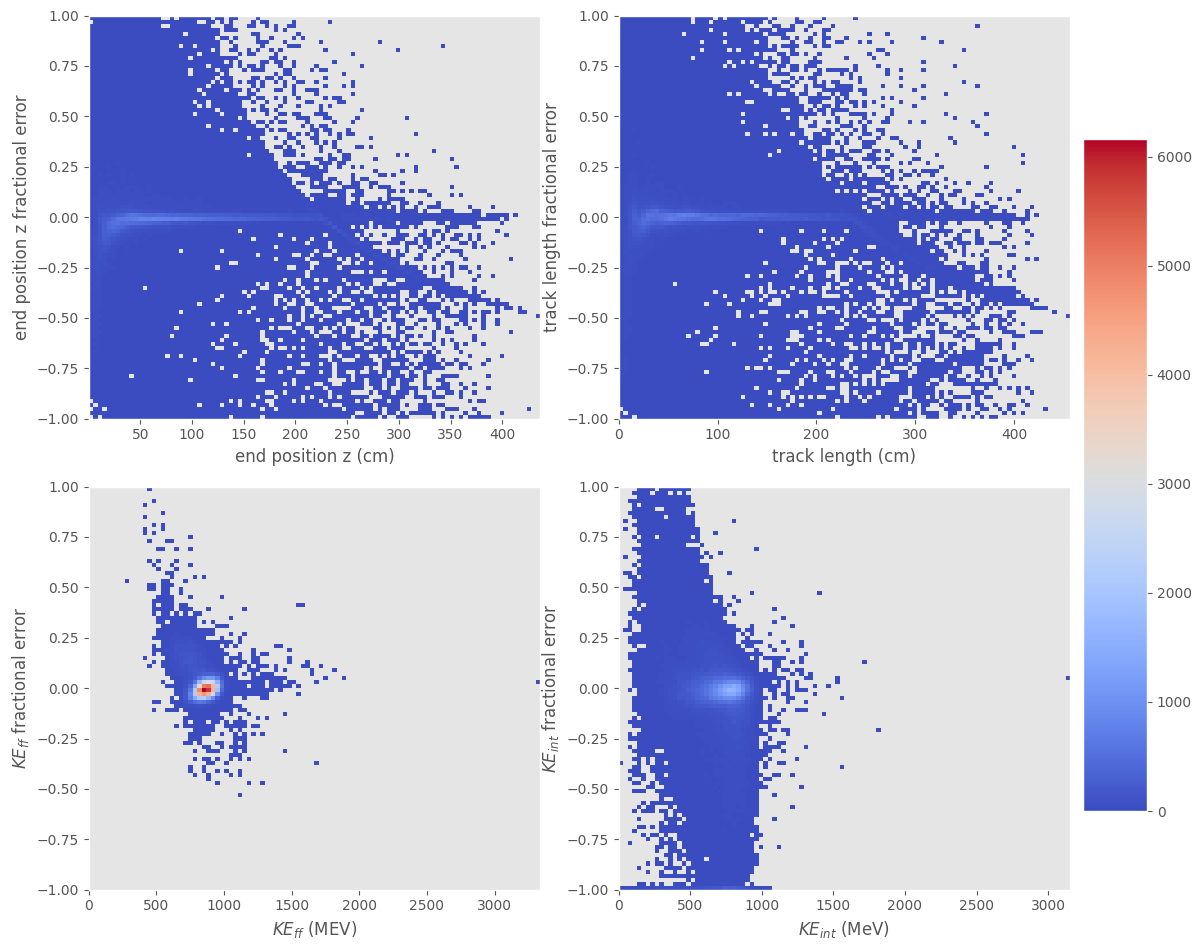

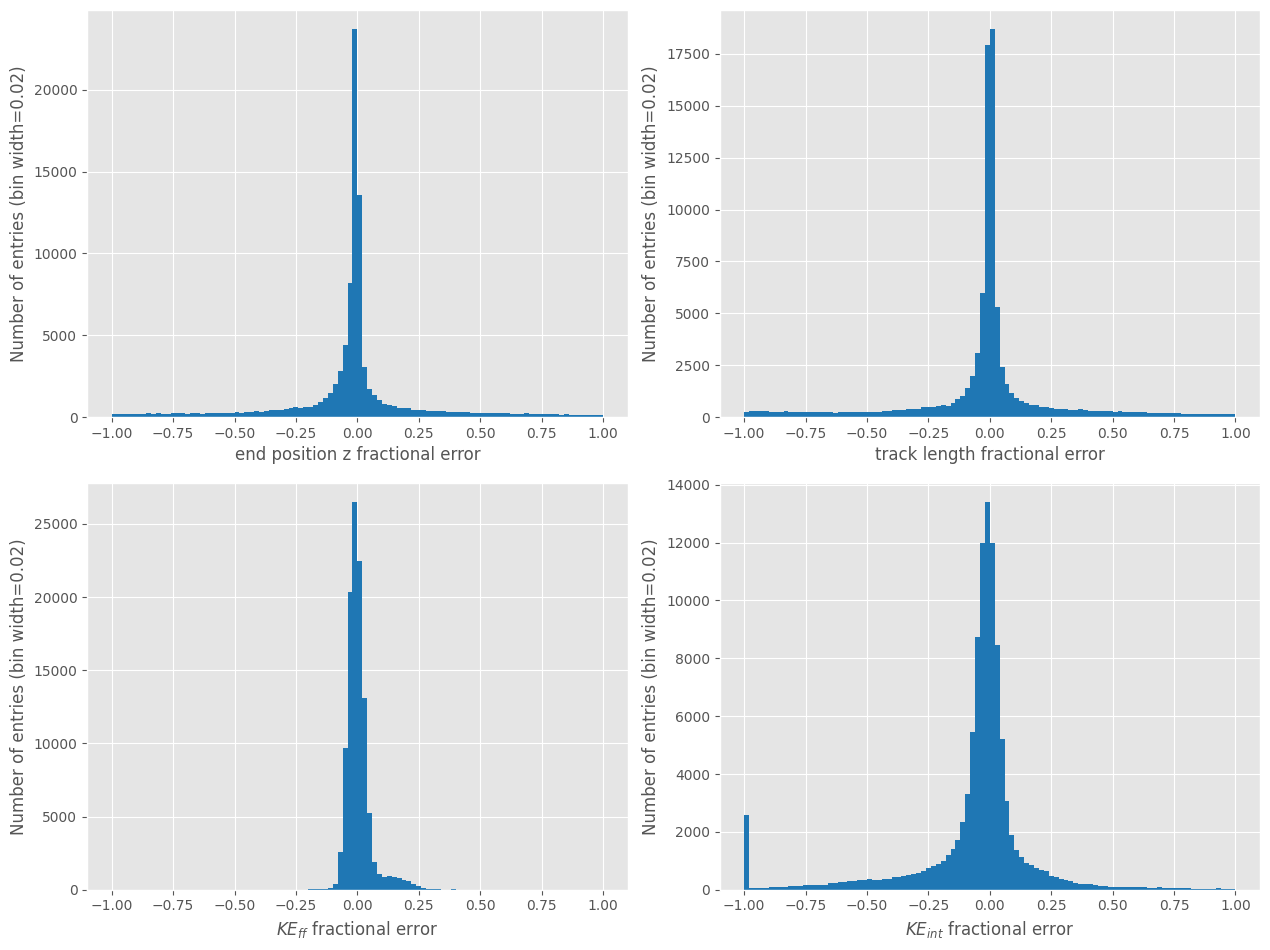

In [63]:
null = reco_parameter["end_pos_z"] == -999
in_tpc = (true_parameter["end_pos_z"] > 0) & (true_parameter["end_pos_z"] < 700)

x_ranges = {"end_pos_z" : None,
            "track_length" : None,
            "KE_ff" : [1500, 2200],
            "KE_int" : [1000, 2050]
            }

fe = {}
means = {}
stds = {}
fe_range = [-1, 1]

labels = {
    "end_pos_z" : "end position z (cm)",
    "track_length" : "track length (cm)",
    "KE_ff" : "$KE_{init}$ (MEV)",
    "KE_int" : "$KE_{int}$ (MeV)"
}

fe_labels = {
    "end_pos_z" : "end position z fractional error",
    "track_length" : "track length fractional error",
    "KE_ff" : "$KE_{init}$ fractional error",
    "KE_int" : "$KE_{int}$ fractional error"
}


for k in reco_parameter:
    fe[k] = ((reco_parameter[k] - true_parameter[k]) / true_parameter[k])[(~null) & in_tpc]
    mask = (fe[k] < max(fe_range)) & (fe[k] > min(fe_range))
    means[k] = np.nanmean(fe[k][mask])
    stds[k] = np.nanstd(fe[k][mask])

for i, k in Plots.IterMultiPlot(fe):
    Plots.PlotHist2D(true_parameter[k][(~null) & in_tpc], fe[k], x_range = x_ranges[k], y_range = fe_range, xlabel = f"True {labels[k]}", ylabel = fe_labels[k], newFigure = False)
pdf.Save()

x = []
y = []
for k in fe:
    x.append(np.array(true_parameter[k][(~null) & in_tpc]))
    y.append(np.array(fe[k]))

Plots.PlotHist2DComparison(x, y, bins = 100, x_range = None, y_range = fe_range, cmap = "coolwarm", xlabels = list(labels.values()), ylabels = list(fe_labels.values()))
pdf.Save()

for i, k in Plots.IterMultiPlot(fe):
    Plots.PlotHist(fe[k], range = fe_range, xlabel = fe_labels[k], newFigure = False)
pdf.Save()

print(pd.DataFrame([means, stds], index = ["mean", "rms"]))

# KE_int_reco_err = KE_int_bb_err(reco_parameter["KE_ff"], reco_parameter["track_length"], 50, reco_parameter["track_length"] - true_parameter["track_length"], reco_parameter["KE_ff"] - true_parameter["KE_ff"])
# ratio = KE_int_reco_err[1]/KE_int_reco_err[0]
# ratio = ratio[(ratio != np.inf) & in_tpc & null]
# print(np.mean(ratio))
# print(np.std(ratio))

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:695: RuntimeWarning: invalid value encountered in divide
  mean_energy = sum_energy / counts
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:697: RuntimeWarning: invalid value encountered in divide
  std_energy = np.divide(sum_energy_sqr, counts) - mean_energy**2
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:170: RuntimeWarning: invalid value encountered in sqrt
  beta = (1 - (1/gamma)**2)**0.5
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(


mean

thin_slice  energy_slice
true -189.611306   -172.263421
sim   -85.085094   -194.917452

rms

thin_slice  energy_slice
true  493.545996    156.767638
sim   396.103596    160.371687

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:887: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


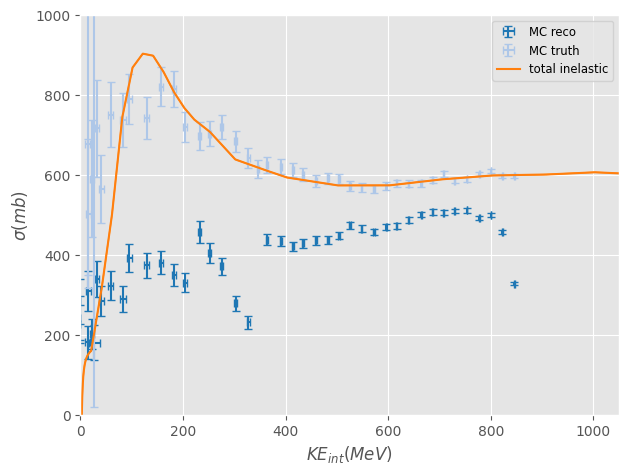

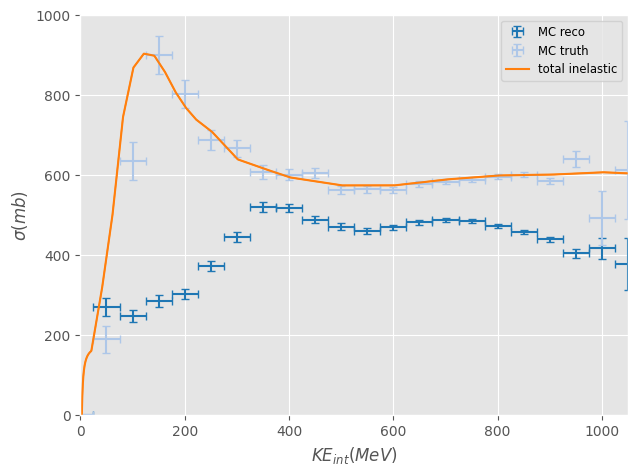

In [75]:
def chi_sqr(o, e):
    n = (o - e)[e != 0]
    return np.nansum(n**2 / e[e !=0 ]) / sum(~np.isnan(n))

spatial_slices = cross_section.Slices(10, -10, 700)
energy_slices = cross_section.Slices(50, 0, 1050, True)
regions = truth_regions(events)
true_mean_energy = cross_section.ThinSlice.MeanSliceEnergy(true_parameter["KE_int"], events.trueParticles.beam_traj_pos.z[:, -2], spatial_slices)

ts_sim_xs = interp1d(cross_sections.KE, cross_sections.total_inelastic, fill_value = "extrapolate")(true_mean_energy[0])
es_sim_xs = interp1d(cross_sections.KE, cross_sections.total_inelastic, fill_value = "extrapolate")(energy_slices.pos)

true_ts_output = ThinsliceCrossSection(true_parameter["end_pos_z"], regions["total_inelastic"], spatial_slices)
reco_ts_output = ThinsliceCrossSection(reco_parameter["end_pos_z"], regions["total_inelastic"], spatial_slices)
true_es_output = ESliceCrossSection(true_parameter["KE_int"], true_parameter["KE_ff"], regions["total_inelastic"], ~in_tpc, energy_slices, Particle.from_pdgid(211))
reco_es_output = ESliceCrossSection(reco_parameter["KE_int"], reco_parameter["KE_ff"], regions["total_inelastic"], ~in_tpc, energy_slices, Particle.from_pdgid(211))

def xs_res_stat(reco, true, sim, op : callable):
    return {
        "true" : op(reco - true),
        "sim" : op(reco - sim)
    }

means = {
    "thin_slice" : xs_res_stat(reco_ts_output['xs'], true_ts_output['xs'], ts_sim_xs, np.nanmean),
    "energy_slice" : xs_res_stat(reco_es_output["xs"], true_es_output["xs"], es_sim_xs, np.nanmean)
}
rms = {
    "thin_slice" : xs_res_stat(reco_ts_output['xs'], true_ts_output['xs'], ts_sim_xs, np.nanstd),
    "energy_slice" : xs_res_stat(reco_es_output["xs"], true_es_output["xs"], es_sim_xs, np.nanstd)
}

print("mean")
print(pd.DataFrame(means))
print("rms")
print(pd.DataFrame(rms))

Plots.Plot(true_mean_energy[0][1:], reco_ts_output["xs"][1:], xerr = true_mean_energy[1][1:], yerr = reco_ts_output["xs_err"][1:], linestyle = "", label = "MC reco")
Plots.Plot(true_mean_energy[0][1:], true_ts_output["xs"][1:], xerr = true_mean_energy[1][1:], yerr = true_ts_output["xs_err"][1:], linestyle = "", label = "MC truth", newFigure = False)
cross_sections.Plot("total_inelastic")
plt.xlim(0, 1050)
plt.ylim(0, 1000)
pdf.Save()


Plots.Plot(energy_slices.pos, reco_es_output["xs"], xerr = energy_slices.width / 2, yerr = reco_es_output["xs_err"], linestyle = "", label = "MC reco")
Plots.Plot(energy_slices.pos, true_es_output["xs"], xerr = energy_slices.width / 2, yerr = true_es_output["xs_err"], linestyle = "", label = "MC truth", newFigure = False)
cross_sections.Plot("total_inelastic")
plt.xlim(0, 1050)
plt.ylim(0, 1000)
pdf.Save()

pdf.close()

# Bethe Bloch Kinetic energy

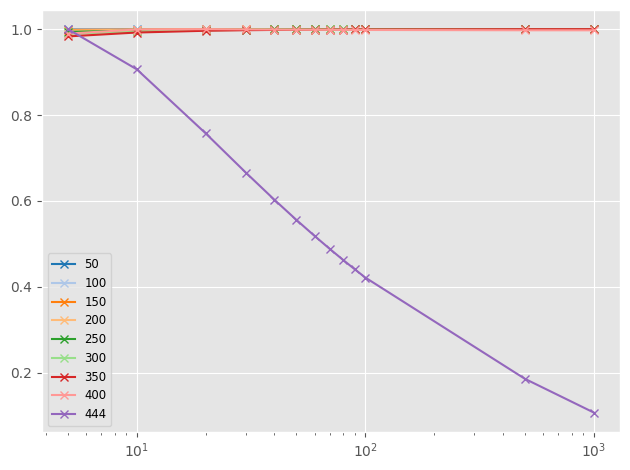

In [76]:
for t in [50, 100, 150, 200, 250, 300, 350, 400, 444]:
    y = []
    x = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 500, 1000]#, 100000]
    for n in x:
        y.append(cross_section.BetheBloch.InteractingKE(np.array([1000]), np.array([t]), Particle.from_pdgid(211), n))
    y = np.array(y)
    y = y/max(y)
    Plots.Plot(x, ak.flatten(y), marker = "x", x_scale = "log", label = t, newFigure = False)

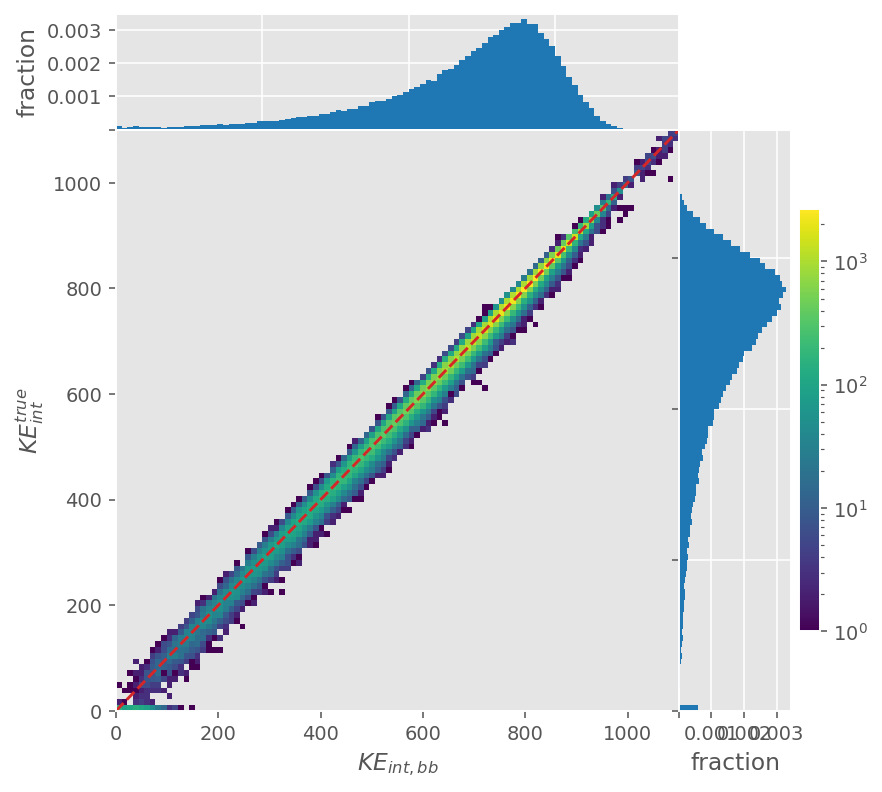

In [63]:
energy_range = [0, 1100]
Plots.PlotHist2DMarginal(true_KE_int_bb[in_tpc], events.trueParticles.beam_traj_KE[:, -2][in_tpc], x_range = energy_range, y_range = energy_range, xlabel = "$KE_{int, bb}$", ylabel = "$KE^{true}_{int}$")

line = np.array([plt.gca().get_xlim(), plt.gca().get_ylim()])
Plots.Plot(line[0], line[1], newFigure = False, color = "C6", linestyle = "--")

In [64]:
def BinParameter(parameter, bin_edges, target):
    binned_data = []
    for i in range(1, len(bin_edges)):
        mask = (parameter > bin_edges[i - 1]) & (parameter < bin_edges[i])
        binned_data.append(target[mask])
    return binned_data

bin_edges = np.linspace(*energy_range, 10)
binned_true_KE_int = BinParameter(true_KE_int_bb, bin_edges, events.trueParticles.beam_traj_KE[:, -2])
# print(binned_true_KE_int)
# for i, d in Plots.IterMultiPlot(binned_true_KE_int):
#     Plots.PlotHist(d, newFigure = False, bins = 50)


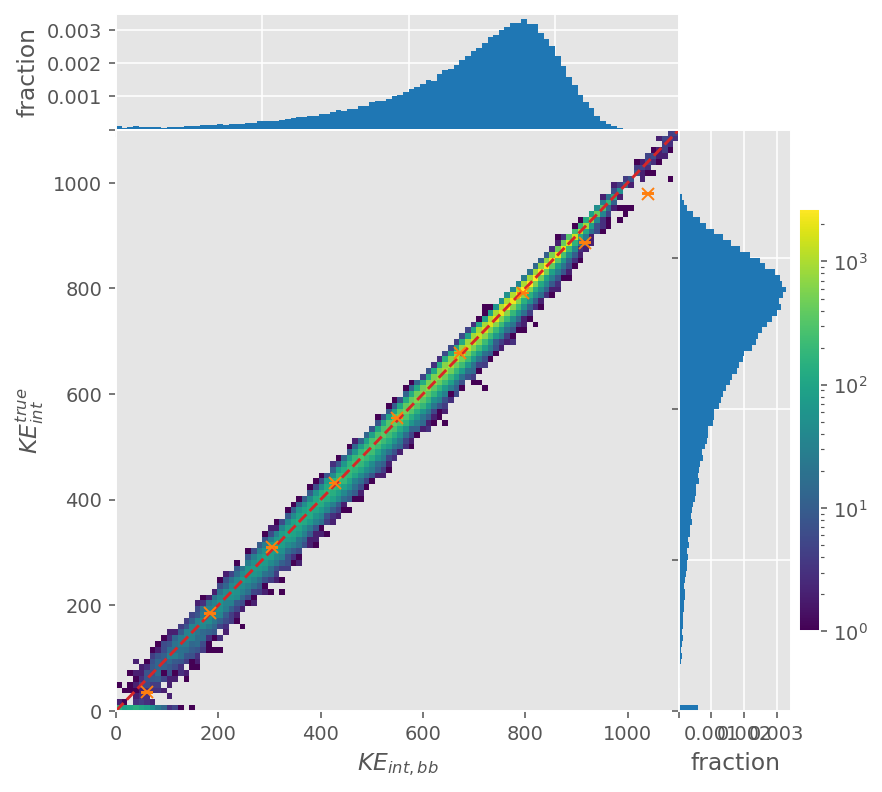

In [65]:
Plots.PlotHist2DMarginal(true_KE_int_bb[in_tpc], events.trueParticles.beam_traj_KE[:, -2][in_tpc], x_range = energy_range, y_range = energy_range, xlabel = "$KE_{int, bb}$", ylabel = "$KE^{true}_{int}$")

line = np.array([plt.gca().get_xlim(), plt.gca().get_ylim()])
Plots.Plot(line[0], line[1], newFigure = False, color = "C6", linestyle = "--")


mean = ak.mean(binned_true_KE_int, axis = -1)
err = ak.std(binned_true_KE_int, axis = -1) / np.sqrt(ak.num(binned_true_KE_int) - 1)
x = (bin_edges[1:] + bin_edges[:-1]) / 2
Plots.Plot(x, mean, yerr = err, newFigure = False, color = "C2", marker = "x", linestyle = "")

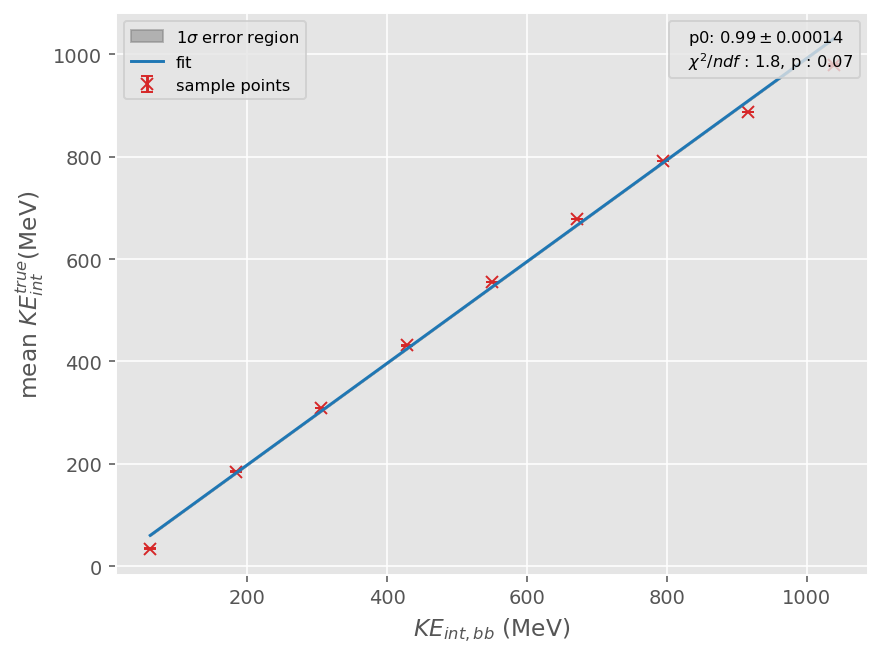

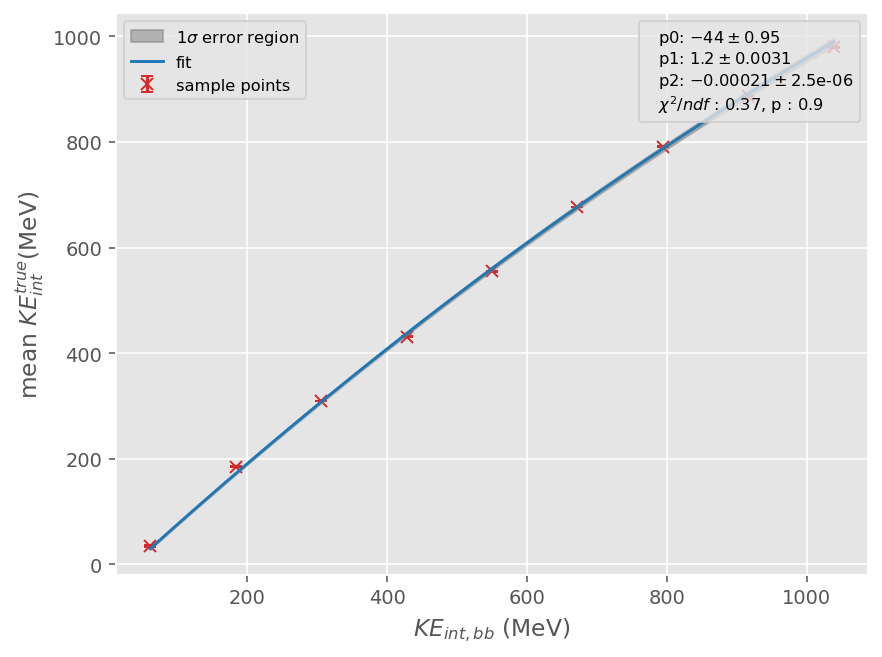

In [71]:
class line(Fitting.FitFunction):
    n_params = 1

    @staticmethod
    def func(x, m):
        return m * x

    @staticmethod
    def p0(x, y):
        return None

    @staticmethod
    def bounds(x, y):
        return ([-np.inf], [np.inf])


Fitting.Fit(x, mean, err, line, plot = True, xlabel = "$KE_{int, bb}$ (MeV)", ylabel = "mean $KE^{true}_{int}$(MeV)")
plt.figure()
bb_corection = Fitting.Fit(x, mean, err, Fitting.poly2d, plot = True, xlabel = "$KE_{int, bb}$ (MeV)", ylabel = "mean $KE^{true}_{int}$(MeV)")[0]


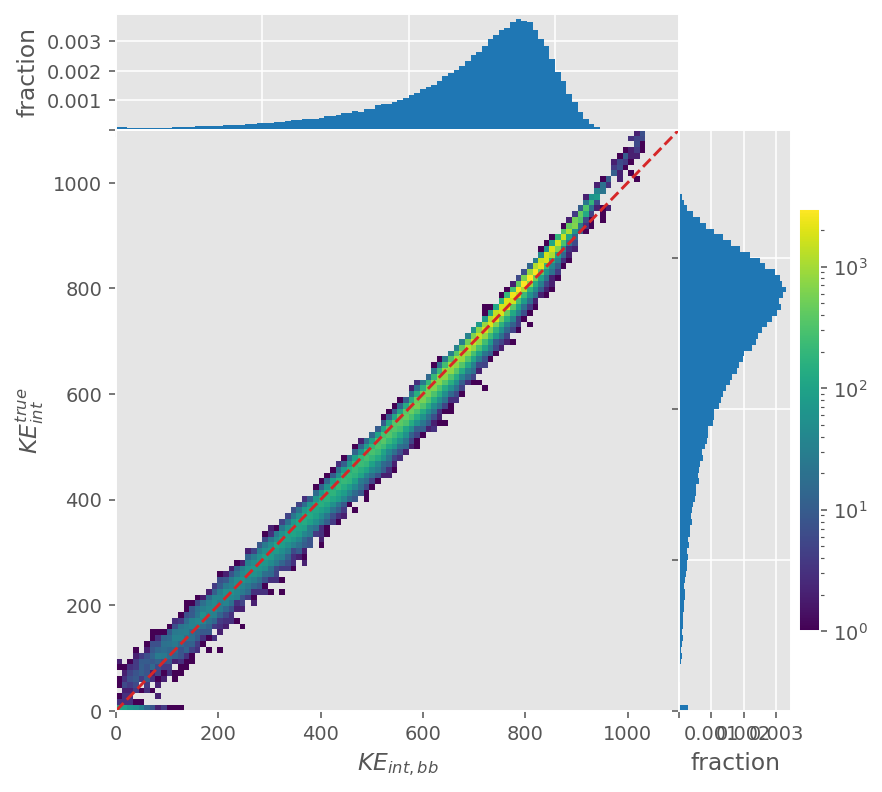

In [52]:
true_KE_int_bb_corrected = Fitting.poly2d.func(true_KE_int_bb, *bb_corection)
Plots.PlotHist2DMarginal(true_KE_int_bb_corrected[in_tpc], events.trueParticles.beam_traj_KE[:, -2][in_tpc], x_range = energy_range, y_range = energy_range, xlabel = "$KE_{int, bb}$", ylabel = "$KE^{true}_{int}$")

line = np.array([plt.gca().get_xlim(), plt.gca().get_ylim()])
Plots.Plot(line[0], line[1], newFigure = False, color = "C6", linestyle = "--")
# true_KE_int_bb = true_KE_int_bb_corrected

(array([2.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 3.0000e+00, 2.0000e+00, 5.0000e+00, 4.0000e+00,
        4.0000e+00, 5.0000e+00, 1.0000e+01, 9.0000e+00, 1.3000e+01,
        1.2000e+01, 2.3000e+01, 3.4000e+01, 2.8000e+01, 5.0000e+01,
        6.2000e+01, 8.3000e+01, 8.3000e+01, 9.6000e+01, 1.3800e+02,
        1.6600e+02, 2.0500e+02, 2.5100e+02, 2.8600e+02, 3.3900e+02,
        4.1300e+02, 4.9000e+02, 6.2800e+02, 7.6000e+02, 9.1700e+02,
        1.0540e+03, 1.2300e+03, 1.5180e+03, 1.7190e+03, 2.0670e+03,
        2.4060e+03, 2.9800e+03, 3.5310e+03, 4.1170e+03, 4.9000e+03,
        5.5400e+03, 6.2610e+03, 7.4380e+03, 8.4660e+03, 1.1036e+04,
        5.8390e+03, 4.6100e+03, 3.7180e+03, 3.3230e+03, 2.9520e+03,
        2.7420e+03, 2.3780e+03, 2.1600e+03, 1.9680e+03, 1.8440e+03,
        1.6730e+03, 1.5690e+03, 1.3730e+03, 1.3330e+03, 1.2080e+03,
        1.0550e+03, 1.0030e+03, 9.9900e+02, 9.0700e+02, 7.9700e+02,
        7.9500e+02, 7.1200e+02, 6.6300e+02, 5.34

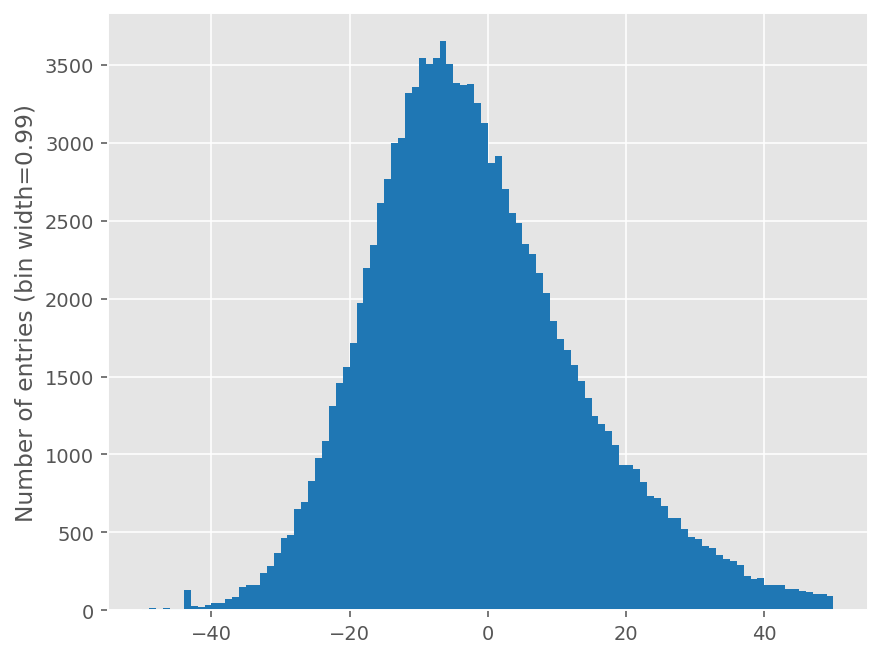

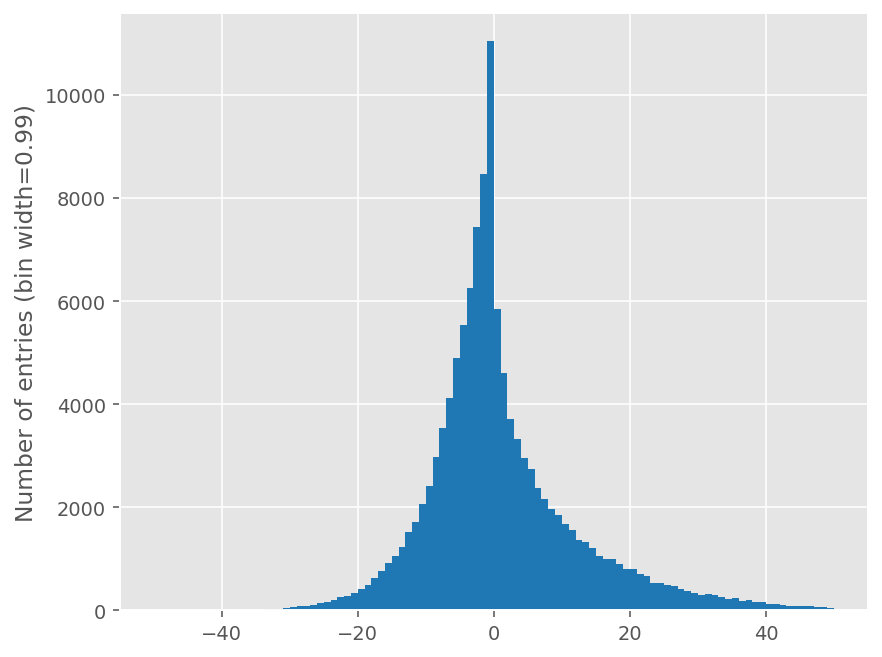

In [53]:
Plots.PlotHist(true_KE_int_bb_corrected[in_tpc] - events.trueParticles.beam_traj_KE[:, -2][in_tpc], range = [-50, 50])
Plots.PlotHist(true_KE_int_bb[in_tpc] - events.trueParticles.beam_traj_KE[:, -2][in_tpc], range = [-50, 50])


# Modified Kinetic energy equation

In [23]:
pdf = Plots.PlotBook("new_equation_1GeV.pdf", False)

In [25]:
regions = truth_regions(events)
true_KE_int_bb = cross_section.BetheBloch.InteractingKE(events.trueParticles.beam_KE_front_face, events.trueParticles.beam_track_length, 50)
in_tpc = (events.trueParticles.beam_traj_pos.z[:, -2] > 0) & (events.trueParticles.beam_traj_pos.z[:, -2] < 700)

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in multiply
  result = getattr(ufunc, method)(


In [28]:
energy_slices = cross_section.Slices(100, 0, 1000, True)

output_old = {}
output_new = {}
for r in regions:
    output_old[r] = ESliceCrossSection(true_KE_int_bb, events.trueParticles.beam_KE_front_face, regions[r], ~in_tpc, energy_slices, Particle.from_pdgid(211))
    output_new[r] = ESliceCrossSectionModified(true_KE_int_bb, events.trueParticles.beam_KE_front_face, regions[r], ~in_tpc, energy_slices, Particle.from_pdgid(211))

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:179: RuntimeWarning: invalid value encountered in sqrt
  beta = (1 - (1/gamma)**2)**0.5
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(


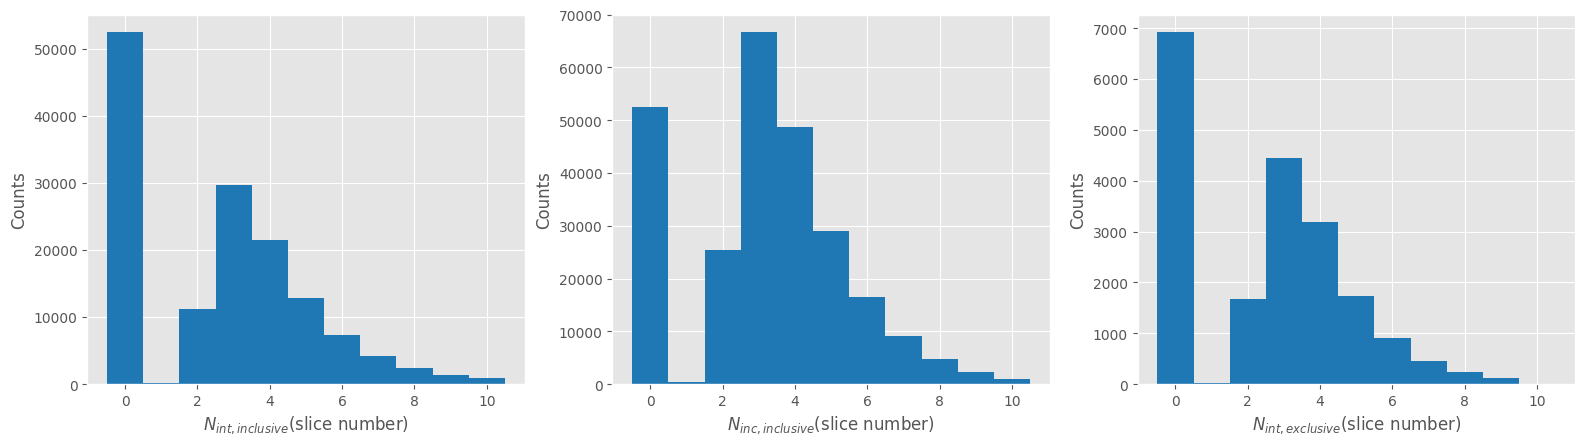

In [36]:
labels = {
    "n_end" : "$N_{int, inclusive}$",
    "n_incident" : "$N_{inc, inclusive}$",
    "n_interact_exclusive" : "$N_{int, exclusive}$"}
for _, h in Plots.IterMultiPlot(labels):
    plt.bar(energy_slices.num, output_new["charge_exchange"][h][:-1], width = 1)
    plt.xlabel(labels[h] + "(slice number)")
    plt.ylabel("Counts")
pdf.Save()

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


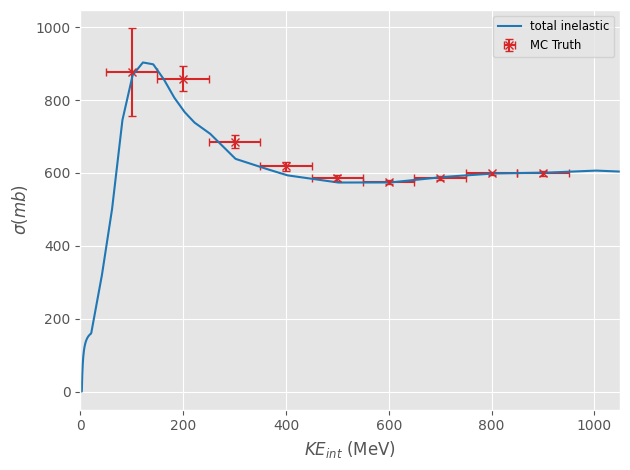

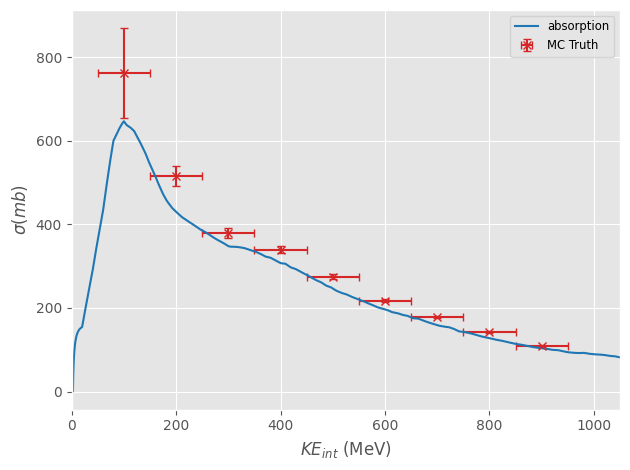

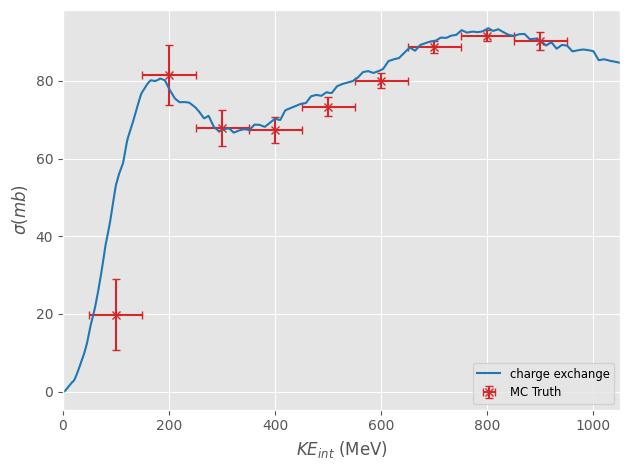

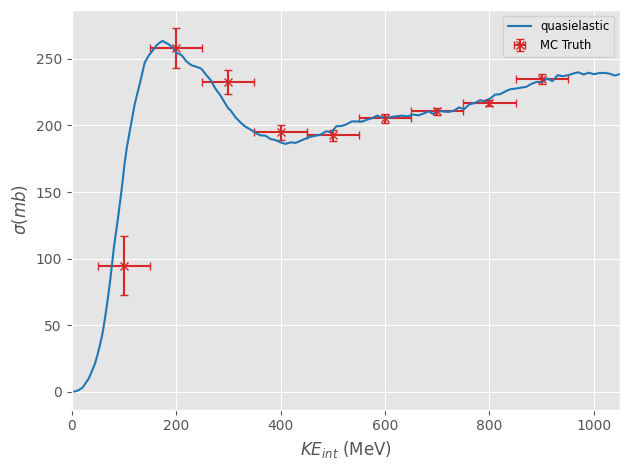

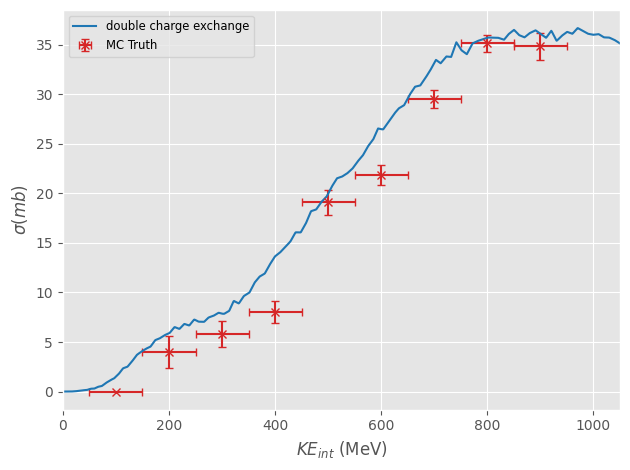

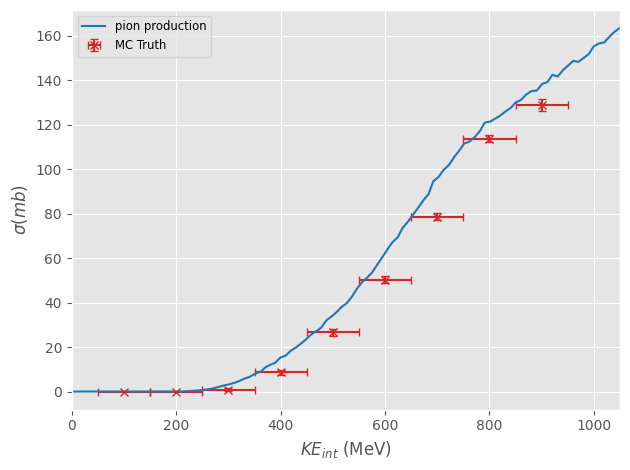

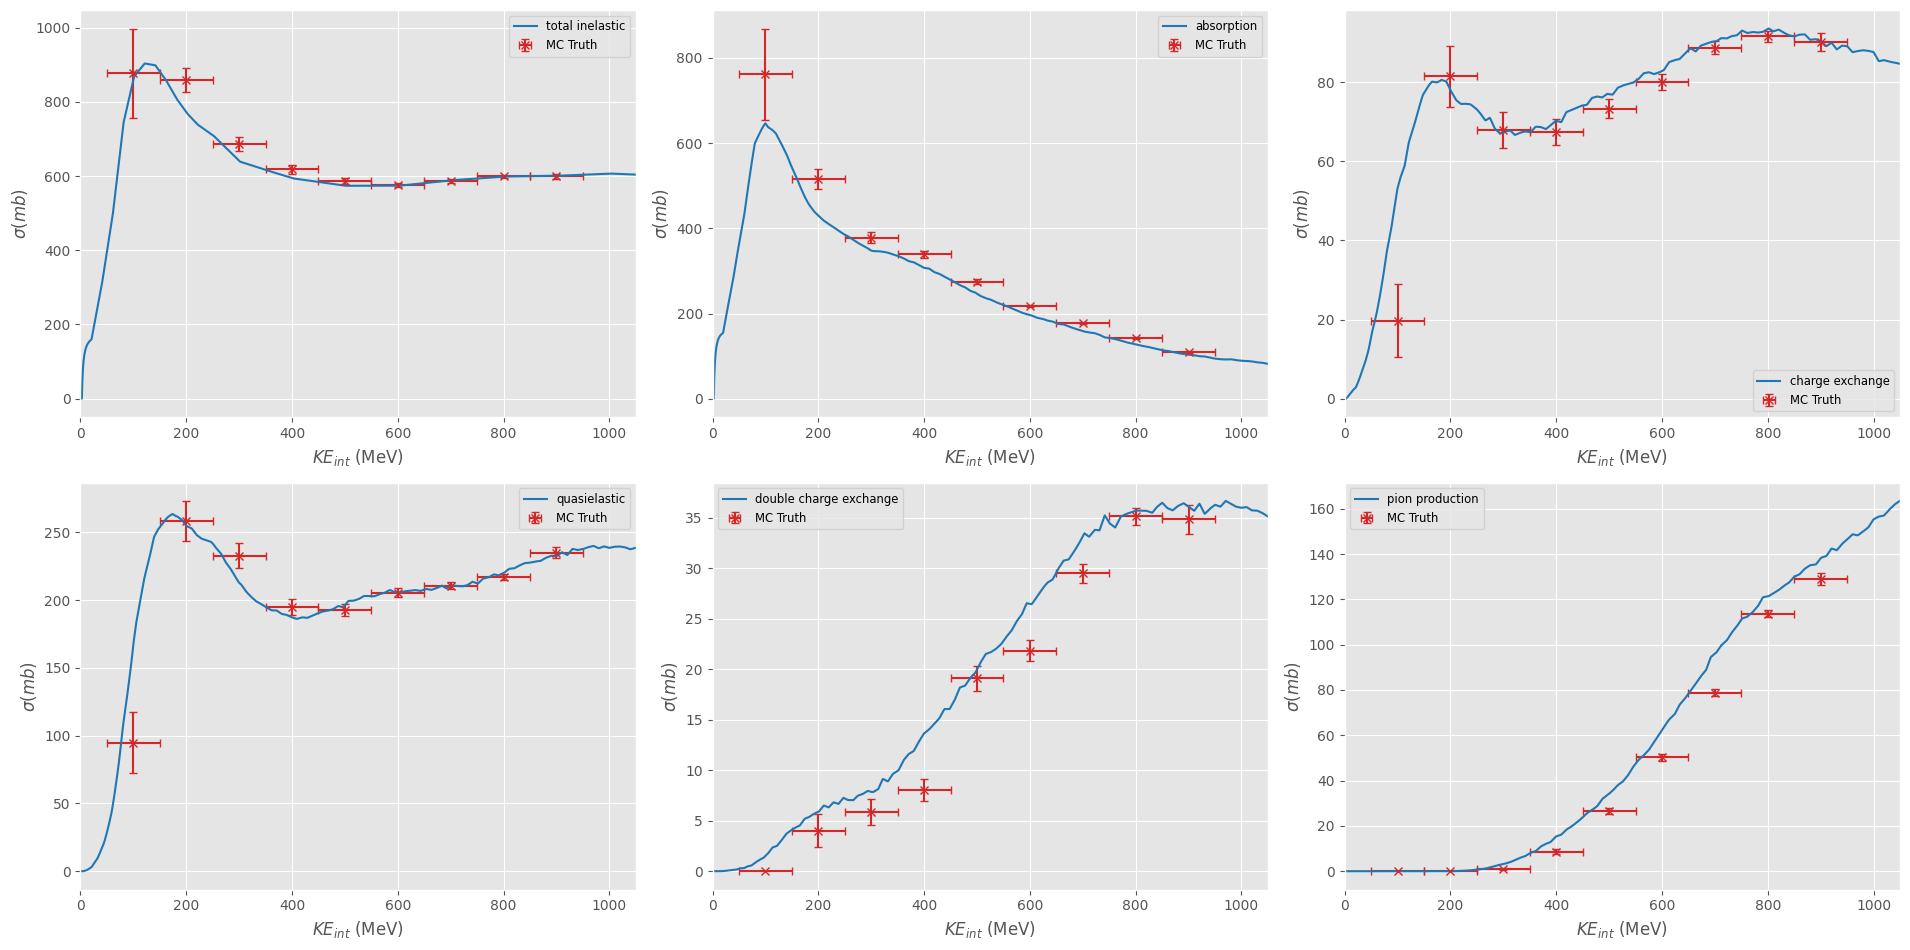

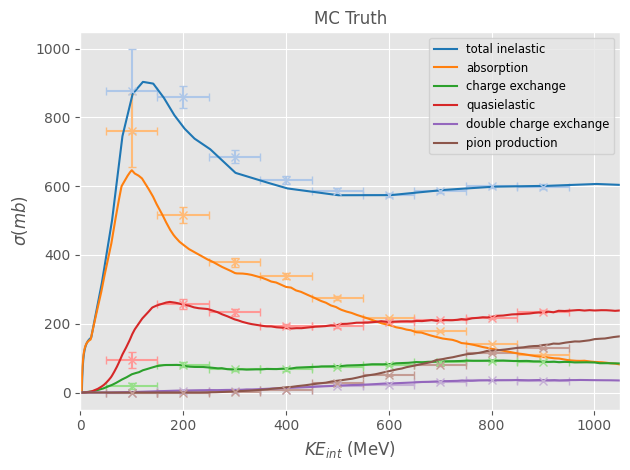

In [37]:
for r in regions:
    plt.figure()
    cross_sections.Plot(r)
    # Plots.Plot(energy_slices.pos[:-1], output_old[r]["xs"][:-1], yerr = output_old[r]["xs_err"][:-1], color = "C6", xerr = energy_slices.width/2, linestyle = "", marker = "x",label = f"MC Truth", newFigure = False)
    Plots.Plot(energy_slices.pos[1:-1], output_new[r]["xs"][1:-1], yerr = output_new[r]["xs_err"][1:-1], color = "C6", xerr = energy_slices.width/2, linestyle = "", marker = "x",label = "MC Truth", newFigure = False)
    plt.xlim(0, 1050)
    pdf.Save()

for _, r in Plots.IterMultiPlot(regions):
    cross_sections.Plot(r)
    Plots.Plot(energy_slices.pos[1:-1], output_new[r]["xs"][1:-1], yerr = output_new[r]["xs_err"][1:-1], color = "C6", xerr = energy_slices.width/2, linestyle = "", marker = "x",label = "MC Truth", newFigure = False)
    plt.xlim(0, 1050)
    pdf.Save()

plt.figure()
for r in regions:
    cross_sections.Plot(r)
    Plots.Plot(energy_slices.pos[1:-1], output_new[r]["xs"][1:-1], yerr = output_new[r]["xs_err"][1:-1], xerr = energy_slices.width/2, linestyle = "", marker = "x", title = "MC Truth", newFigure = False)
    plt.xlim(0, 1050)
    pdf.Save()

pdf.close()

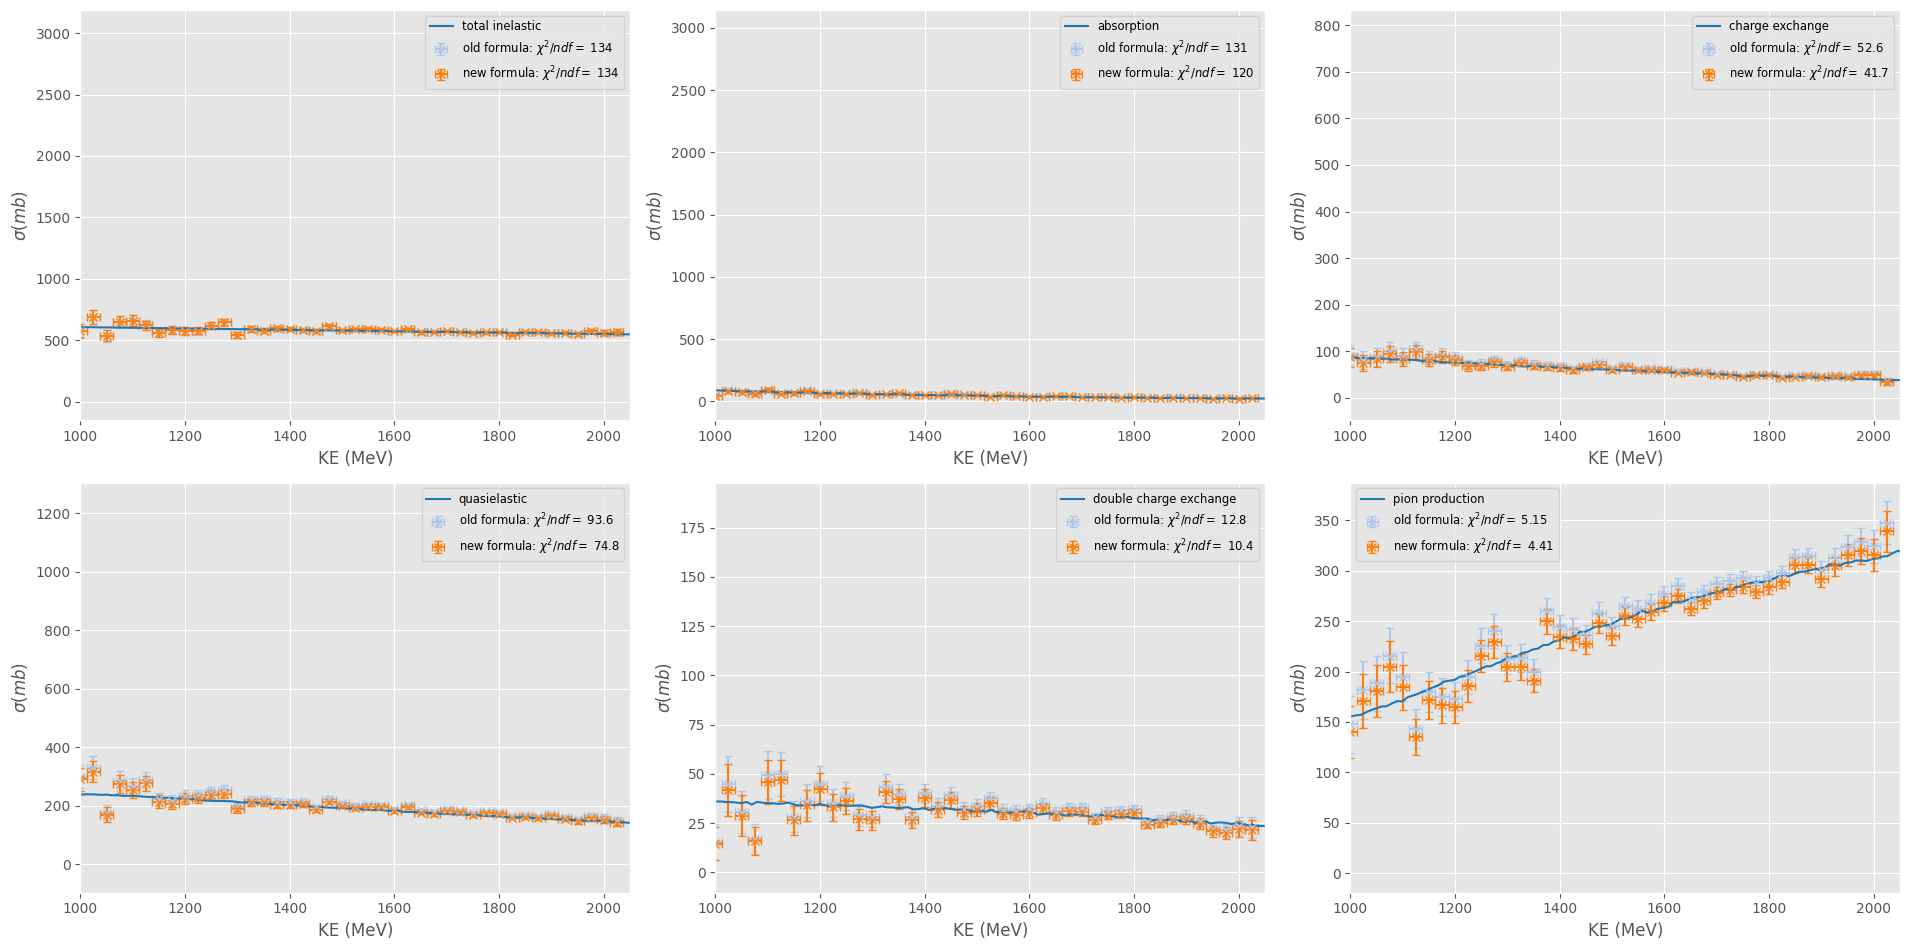

In [17]:
def chi_sqr_ndf(observed, expected):
    safe_observed = np.where((abs(observed) == np.inf) | (abs(observed) == 0), np.nan, observed)
    safe_expected = np.where((abs(expected) == np.inf) | (abs(expected) == 0), np.nan, expected)
    return np.nansum((safe_observed - safe_expected)**2/safe_expected)/len(safe_expected)


for _, r in Plots.IterMultiPlot(regions, sharex = True):
    cross_sections.Plot(r)

    expected = interp1d(cross_sections.KE, getattr(cross_sections, r), fill_value = "extrapolate")(energy_slices.pos[:-2])

    Plots.Plot(energy_slices.pos[:-2], output_old[r]["xs"][:-2], yerr = output_old[r]["xs_err"][:-2], xerr = energy_slices.width/2, linestyle = "", marker = "x",label = f"old formula: $\chi^{2}/ndf = $ {chi_sqr_ndf(output_old[r]['xs'][:-2], expected):.3g}", newFigure = False)
    Plots.Plot(energy_slices.pos[:-2], output_new[r]["xs"][:-2], yerr = output_new[r]["xs_err"][:-2], xerr = energy_slices.width/2, linestyle = "", marker = "x",label = f"new formula: $\chi^{2}/ndf = $ {chi_sqr_ndf(output_new[r]['xs'][:-2], expected):.3g}", newFigure = False)
    plt.xlim(1000, 2050)
pdf.Save()
pdf.close()

In [40]:
analysis_inputs = {k : cross_section.LoadObject(v) for k, v in args.analysis_input.items()}

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:179: RuntimeWarning: invalid value encountered in sqrt
  beta = (1 - (1/gamma)**2)**0.5


{'mc true': 4.7051973007072565}

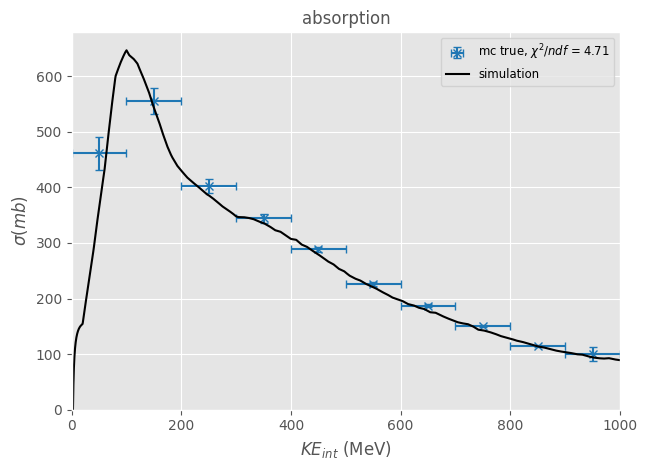

In [65]:
energy_slices = cross_section.Slices(100, 0, 1000, True)

p = "absorption"

hists = analysis_inputs["mc_cheated"].CreateHistograms(energy_slices, p, False)

dEdX = cross_section.EnergySlice.Slice_dEdX(energy_slices, cross_section.Particle.from_pdgid(211))

xs = cross_section.EnergySlice.CrossSection(hists["int_ex"][1:], hists["int"][1:], hists["inc"][1:], dEdX, args.energy_slices.width)

cross_section.PlotXSComparison({"mc true" : xs}, energy_slices, p)

In [63]:
regions = truth_regions(events)

print("inelastic", sum(regions["total_inelastic"]), sum(analysis_inputs["mc_cheated"].inclusive_process), all(regions["total_inelastic"] == analysis_inputs["mc_cheated"].inclusive_process))

for k, v in analysis_inputs["mc_cheated"].exclusive_process.items():
    print(k, sum(regions[k]), sum(v), all(regions[k] == v))

inelastic 137883 137883 True

absorption 36460 42807 False

charge_exchange 19709 19709 True

single_pion_production 57317 57317 True

pion_production 24397 24397 True